In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from sklearn.model_selection import train_test_split
import random
import math
from numpy.random import seed
import joblib
import torch.nn.functional as F
from sklearn import preprocessing

#Reproducability of Results
seed(1)
torch.cuda.manual_seed(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class DNNRegression(torch.nn.Module):
    
    def __init__(self,number_of_inputs,hidden_layer_size,number_of_outputs):
        super(DNNRegression, self).__init__()
        self.hidden = torch.nn.Linear(number_of_inputs,hidden_layer_size)
        self.hidden2 = torch.nn.Linear(hidden_layer_size,512)
        self.hidden3 = torch.nn.Linear(512,1024)
        self.predict = torch.nn.Linear(1024,number_of_outputs)
        
    def forward(self,x):
        x = F.relu(self.hidden(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.predict(x))
        return x

In [3]:
#Dataset Import and Transform into Torch Training/Testing Tensors
label_enc_tx = preprocessing.MinMaxScaler(feature_range=(0,1))
label_enc_no_tx = preprocessing.MinMaxScaler(feature_range=(0,1))

def Dataset(with_tx):
    if with_tx:
        data = pd.read_csv('Dataset/data_tx.csv')
        train_data, test_data = train_test_split(data.values,test_size=0.2)
        return label_enc_tx.fit_transform(train_data),label_enc_tx.transform(test_data)
    else:
        data = pd.read_csv('Dataset/data_no_tx.csv')
        train_data,test_data = train_test_split(data.values,test_size=0.2)
    return label_enc_no_tx.fit_transform(train_data),label_enc_no_tx.transform(test_data)

In [4]:
#Import DNN Regression Model for EC/MS/TP predictions
def load_predictor(with_tx):
    if with_tx:
        scaler = joblib.load('Models/label_enc_tx.save')
        model = DNNRegression(10,256,3)
        model.load_state_dict(torch.load('Models/model_tx.pt'))
        return model,scaler
    else:
        scaler = joblib.load('Models/label_enc_no_tx.save')
        model = DNNRegression(7,256,2)
        model.load_state_dict(torch.load('Models/model_no_tx.pt'))
        return model,scaler

In [5]:
#RL Model Common Hyper parameters

number_of_epochs = 1
learning_rate = 0.0001
hidden_layer_size = 258
INITIAL_EPSILON = 1
FINAL_EPSILON = 0.01
EPSILON_DECAY = 50000
GAMMA = 0.9
NUMBER_OF_ACTIONS = 3
MINIBATCH_SIZE = 32
REPLAY_MEMORY_SIZE = 10000
NUMBER_OF_SIM = 7

In [6]:
def save_model(model,epoch,optimiser,loss,with_tx,model_type,target_kpi):
    model_state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimiser.state_dict(),
        'loss':loss,
        }
    if with_tx: 
        tx = "tx"
    else:
        tx = "no_tx"
    
    model_save_name = F"model_{tx}_{model_type}_{target_kpi}.tar"
    path = F"Models/{model_save_name}"
    torch.save(model_state, path)

In [7]:
#Reward Calculation

def CalculateReward(current_state,epoch,target_kpi,with_tx):
    if epoch == NUMBER_OF_SIM:
        terminal = True 
    else: terminal = False
    if with_tx:
        ms = current_state[1]
        ec = current_state[0]
        tp = current_state[12]
    else:
        ms = current_state[1]
        ec = current_state[0]
    if target_kpi == "ms":
        # goal is to reduce the ms
        return 1-ms,terminal
    elif target_kpi == "ec":
        return 1-ec,terminal
    elif target_kpi == "tp":
        return 1-tp,terminal
    else:
        if with_tx:
            return (0.3*(1-ec) + 0.3*tp + 0.3*(1-ms)),terminal
        else:
            return 1-(0.5*ec+0.5*ms)
    return -1,False


In [8]:
# [0, 100010, 101]
scaled_timers_tx = [0.0,0.00100989901009899,0.9999999999999999]
# [0, 1, 101, 100010, 11]
scaled_timers_no_tx = [0.0,9.99900009999e-06,0.00010998900109989,0.00100989901009899,0.9999999999999999]

def Increase_Timer(prev_timer,with_tx):
    if with_tx:
        index = scaled_timers_tx.index(prev_timer)
        return scaled_timers_tx[min(index+1,2)]
    else:
        index = scaled_timers_no_tx.index(prev_timer)
        return scaled_timers_no_tx[min(index+1,2)]

def Decrease_Timer(prev_timer,with_tx):
     if with_tx:
        index = scaled_timers_tx.index(prev_timer)
        return scaled_timers_tx[max(index-1,0)]
     else:
        index = scaled_timers_no_tx.index(prev_timer)
        return scaled_timers_no_tx[max(index-1,0)]

In [9]:
def Random_Action(output,epsilon):
    action = torch.zeros([NUMBER_OF_ACTIONS], dtype=torch.float32)
    random_action = random.random() < epsilon

    if random_action:
        action[random.randrange(NUMBER_OF_ACTIONS)] = 1
    else:
        with torch.no_grad():
            action[torch.argmax(output).item()] = 1
            
    return action

In [10]:
# ACTIONS --- 0 - do nothing, 1 - increase active timer, 2 - decrease active timer
# INPUT Columns TX - [ec,ms,tx,ecl,loc,ectx,mstx,duration,interval,psize,active_timer,tau,tp]
# INPUT Columns No TX - [ec,ms,ecl,loc,duration,interval,psize,active_timer,tau] 

do_nothing = torch.tensor([1,0,0]).float()
increase_timer = torch.tensor([0,1,0]).float()
decrease_timer = torch.tensor([0,0,1]).float()

def Take_Action(current,output,predictor,scaler,with_tx):
    if with_tx:
        if torch.equal(output,do_nothing):
            return current
        elif torch.equal(output,increase_timer):
            new_timer = Increase_Timer(current[10],with_tx)
        else:
            new_timer = Decrease_Timer(current[10],with_tx)
            
        #change active timer to new timer
        current[10] = new_timer
        next_s = current
        #drop ec,ms,tp
        pre_predicted_features = np.delete(current,[0,1,12])
        #Normalise pre predicted features into the same normalisation scale
#         pre_predicted_features = scaler.transform(pre_predicted_features.reshape(1,-1))
        #input features into predictor
        with torch.no_grad():
            predicted_features = predictor(torch.Tensor(pre_predicted_features))
        #append predicted into new list
        next_s[0] = pre_predicted_features[0]
        next_s[1] = pre_predicted_features[1]
        next_s[12] = pre_predicted_features[2]
        #return list
        return next_s
           
    else:
        if torch.equal(output,do_nothing):
            return current
        elif torch.equal(output,increase_timer):
            new_timer = Increase_Timer(current[7],with_tx)
        else:
            new_timer = Decrease_Timer(current[7],with_tx)
        
        current[7] = new_timer
        next_s = current
        #drop ec,ms,tp
        pre_predicted_features = np.delete(next_s,[0,1])
        #Normalise pre predicted features into the same normalisation scale
#         pre_predicted_features = scaler.transform(pre_predicted_features)
        #input features into predictor
        with torch.no_grad():
            predicted_features = predictor(torch.Tensor(pre_predicted_features))
        #append predicted into new list
        next_s[0] = pre_predicted_features[0]
        next_s[1] = pre_predicted_features[1]
        #return list
        return next_s


In [11]:
def minibatch_reward(model,replay_memory,NUMBER_OF_INPUTS):
    minibatch = random.sample(replay_memory, min(len(replay_memory), MINIBATCH_SIZE))

    current_batch = torch.zeros(len(minibatch),NUMBER_OF_INPUTS).to(device)
    action_batch = torch.zeros(len(minibatch),NUMBER_OF_ACTIONS).to(device)
    reward_batch = torch.zeros(len(minibatch)).to(device)
    next_state_batch = torch.zeros(len(minibatch),NUMBER_OF_INPUTS).to(device)
    terminal_state_batch = []
    for idx,data_point in enumerate(minibatch):
        current_batch[idx] = data_point[0]
        action_batch[idx] = data_point[1]
        reward_batch[idx] = data_point[2]
        next_state_batch[idx] = data_point[3]
        terminal_state_batch.append(data_point[4])

    next_state_batch_output = torch.zeros(MINIBATCH_SIZE,NUMBER_OF_INPUTS).to(device)
    for idx in range(next_state_batch.shape[0]):
        next_state_batch_output[idx] = model(next_state_batch[idx]).to(device)[0]

    y_batch = tuple(reward_batch[i] if terminal_state_batch[i]
                        else reward_batch[i] + GAMMA * torch.max(next_state_batch_output[i])
                              for i in range(len(minibatch)))

    return y_batch,current_batch,action_batch,reward_batch,next_state_batch

In [12]:
class RL_GD(nn.Module):
    #defines a gradient descent model (Dueling DQN Architecture)
    
    def __init__(self,number_of_inputs):
        super(RL_GD,self).__init__()

        self.feature = nn.Sequential(
            nn.Linear(number_of_inputs, hidden_layer_size),
            nn.ReLU())
        
        self.advantage = nn.Sequential(
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, NUMBER_OF_ACTIONS))
        
        self.value = nn.Sequential(
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, 1))

    def forward(self,x):
        x = self.feature(x)
        advantage = self.advantage(x)
        value = self.value(x)
        return value + advantage - advantage.mean()

In [13]:
class RL_GA(nn.Module):
    #defines a Genetic Algorithm Approach to Reinforcement learning model
    
    def __init__(self,number_of_inputs,number_of_outputs):
        super(RL_GA,self).__init__()
        
    def forward(self,x):
        return x

In [14]:
def Train_RL(with_tx,model_type,target_kpi):
    
    train_data,_ = Dataset(with_tx)
    predictor = load_predictor(with_tx)
    learn_step_counter = 0
    replay_memory = []
    rewards = []
    loss_history = []
    max_reward = -99999
    
    predictor,scaler = load_predictor(with_tx)
    
    if model_type == "GA":
        model = RL_GA(train_data.shape[1]).to(device)
    else:
        model = RL_GD(train_data.shape[1]).to(device)
        
    optimiser = torch.optim.Adam(model.parameters(),lr=learning_rate)
    criterion = nn.MSELoss()
    epsilon = INITIAL_EPSILON
    
    for epoch in range(number_of_epochs):
        for index,attribute in enumerate(train_data):  
            output = model(torch.Tensor(attribute).to(device))
            action = Random_Action(output,epsilon)
            next_state = Take_Action(attribute,action,predictor,scaler,with_tx)
            reward,terminal = CalculateReward(next_state,0,target_kpi,with_tx)
            for simulated_env in range(NUMBER_OF_SIM):
                next_action = model(torch.Tensor(next_state).to(device))
                next_action = Random_Action(next_action,epsilon)
                next_state = Take_Action(next_state,next_action,predictor,scaler,with_tx)
                reward,terminal = CalculateReward(next_state,simulated_env,target_kpi,with_tx)
                
                rewards.append(reward)
                
                epsilon = FINAL_EPSILON + (INITIAL_EPSILON - FINAL_EPSILON) * math.exp(-1. * learn_step_counter / EPSILON_DECAY)
                
                optimiser.zero_grad()
                
                
                if len(replay_memory) > REPLAY_MEMORY_SIZE:
                    replay_memory.pop(0)
                
                replay_memory.append((torch.Tensor(attribute).to(device), torch.Tensor(action).to(device), reward, torch.Tensor(next_state).to(device), terminal))

                y_batch,current_batch,action_batch,reward_batch,next_state_batch = minibatch_reward(model,replay_memory,train_data.shape[1])
                
                y_batch = torch.Tensor(y_batch).detach().to(device)
                # extract Q-value
                q_value = torch.sum(model(current_batch) * action_batch, dim=1)
                
                loss = criterion(q_value,y_batch)
                
                if sum(reward_batch)/MINIBATCH_SIZE > max_reward:
                    save_model(model,epoch,optimiser,loss,with_tx,model_type,target_kpi)
                
                loss_history.append(loss.item())
                
                loss.backward()
                optimiser.step()
                
            learn_step_counter += 1
            print('Epoch: {}/{},Runs: {}/{}, Loss: {:.6f}, Average Reward: {:.2f}, Epsilon: {:.4f}'.format(epoch,number_of_epochs,index,train_data.shape[0],loss.item(),sum(reward_batch)/MINIBATCH_SIZE,epsilon))
            
    return loss_history,rewards

In [15]:
def Test_RL(with_tx,model):
    
    test_x,test_y = Dataset(with_tx).get_testing_dataset(with_tx)
    predictor = load_predictor(with_tx)
    
    return None

Epoch: 0/1,Runs: 0/549, Loss: 0.807600, Average Reward: 0.22, Epsilon: 1.0000
Epoch: 0/1,Runs: 1/549, Loss: 0.584257, Average Reward: 0.44, Epsilon: 1.0000
Epoch: 0/1,Runs: 2/549, Loss: 0.376854, Average Reward: 0.56, Epsilon: 1.0000
Epoch: 0/1,Runs: 3/549, Loss: 0.291545, Average Reward: 0.78, Epsilon: 0.9999
Epoch: 0/1,Runs: 4/549, Loss: 0.384341, Average Reward: 0.90, Epsilon: 0.9999
Epoch: 0/1,Runs: 5/549, Loss: 0.502638, Average Reward: 0.95, Epsilon: 0.9999
Epoch: 0/1,Runs: 6/549, Loss: 0.500724, Average Reward: 0.95, Epsilon: 0.9999
Epoch: 0/1,Runs: 7/549, Loss: 0.457838, Average Reward: 0.94, Epsilon: 0.9999
Epoch: 0/1,Runs: 8/549, Loss: 0.547003, Average Reward: 0.94, Epsilon: 0.9998
Epoch: 0/1,Runs: 9/549, Loss: 0.479928, Average Reward: 0.89, Epsilon: 0.9998
Epoch: 0/1,Runs: 10/549, Loss: 0.616970, Average Reward: 0.88, Epsilon: 0.9998
Epoch: 0/1,Runs: 11/549, Loss: 0.666572, Average Reward: 0.86, Epsilon: 0.9998
Epoch: 0/1,Runs: 12/549, Loss: 0.531825, Average Reward: 0.92,

Epoch: 0/1,Runs: 104/549, Loss: 0.000773, Average Reward: 0.84, Epsilon: 0.9979
Epoch: 0/1,Runs: 105/549, Loss: 0.005176, Average Reward: 0.77, Epsilon: 0.9979
Epoch: 0/1,Runs: 106/549, Loss: 0.003358, Average Reward: 0.89, Epsilon: 0.9979
Epoch: 0/1,Runs: 107/549, Loss: 0.002759, Average Reward: 0.89, Epsilon: 0.9979
Epoch: 0/1,Runs: 108/549, Loss: 0.001125, Average Reward: 0.84, Epsilon: 0.9979
Epoch: 0/1,Runs: 109/549, Loss: 0.003976, Average Reward: 0.89, Epsilon: 0.9978
Epoch: 0/1,Runs: 110/549, Loss: 0.000498, Average Reward: 0.86, Epsilon: 0.9978
Epoch: 0/1,Runs: 111/549, Loss: 0.000959, Average Reward: 0.81, Epsilon: 0.9978
Epoch: 0/1,Runs: 112/549, Loss: 0.000974, Average Reward: 0.89, Epsilon: 0.9978
Epoch: 0/1,Runs: 113/549, Loss: 0.000458, Average Reward: 0.89, Epsilon: 0.9978
Epoch: 0/1,Runs: 114/549, Loss: 0.003561, Average Reward: 0.77, Epsilon: 0.9977
Epoch: 0/1,Runs: 115/549, Loss: 0.003174, Average Reward: 0.78, Epsilon: 0.9977
Epoch: 0/1,Runs: 116/549, Loss: 0.002580

Epoch: 0/1,Runs: 207/549, Loss: 0.002972, Average Reward: 0.92, Epsilon: 0.9959
Epoch: 0/1,Runs: 208/549, Loss: 0.006692, Average Reward: 0.78, Epsilon: 0.9959
Epoch: 0/1,Runs: 209/549, Loss: 0.001014, Average Reward: 0.87, Epsilon: 0.9959
Epoch: 0/1,Runs: 210/549, Loss: 0.000787, Average Reward: 0.86, Epsilon: 0.9959
Epoch: 0/1,Runs: 211/549, Loss: 0.000674, Average Reward: 0.80, Epsilon: 0.9958
Epoch: 0/1,Runs: 212/549, Loss: 0.000601, Average Reward: 0.78, Epsilon: 0.9958
Epoch: 0/1,Runs: 213/549, Loss: 0.000206, Average Reward: 0.82, Epsilon: 0.9958
Epoch: 0/1,Runs: 214/549, Loss: 0.000336, Average Reward: 0.88, Epsilon: 0.9958
Epoch: 0/1,Runs: 215/549, Loss: 0.000242, Average Reward: 0.86, Epsilon: 0.9958
Epoch: 0/1,Runs: 216/549, Loss: 0.000413, Average Reward: 0.84, Epsilon: 0.9957
Epoch: 0/1,Runs: 217/549, Loss: 0.005309, Average Reward: 0.77, Epsilon: 0.9957
Epoch: 0/1,Runs: 218/549, Loss: 0.002744, Average Reward: 0.90, Epsilon: 0.9957
Epoch: 0/1,Runs: 219/549, Loss: 0.000319

Epoch: 0/1,Runs: 310/549, Loss: 0.001300, Average Reward: 0.91, Epsilon: 0.9939
Epoch: 0/1,Runs: 311/549, Loss: 0.001200, Average Reward: 0.89, Epsilon: 0.9939
Epoch: 0/1,Runs: 312/549, Loss: 0.000518, Average Reward: 0.84, Epsilon: 0.9938
Epoch: 0/1,Runs: 313/549, Loss: 0.002852, Average Reward: 0.73, Epsilon: 0.9938
Epoch: 0/1,Runs: 314/549, Loss: 0.000765, Average Reward: 0.86, Epsilon: 0.9938
Epoch: 0/1,Runs: 315/549, Loss: 0.003895, Average Reward: 0.92, Epsilon: 0.9938
Epoch: 0/1,Runs: 316/549, Loss: 0.000077, Average Reward: 0.84, Epsilon: 0.9938
Epoch: 0/1,Runs: 317/549, Loss: 0.000529, Average Reward: 0.81, Epsilon: 0.9937
Epoch: 0/1,Runs: 318/549, Loss: 0.007182, Average Reward: 0.64, Epsilon: 0.9937
Epoch: 0/1,Runs: 319/549, Loss: 0.000763, Average Reward: 0.83, Epsilon: 0.9937
Epoch: 0/1,Runs: 320/549, Loss: 0.000707, Average Reward: 0.89, Epsilon: 0.9937
Epoch: 0/1,Runs: 321/549, Loss: 0.000129, Average Reward: 0.80, Epsilon: 0.9937
Epoch: 0/1,Runs: 322/549, Loss: 0.001110

Epoch: 0/1,Runs: 413/549, Loss: 0.003038, Average Reward: 0.94, Epsilon: 0.9919
Epoch: 0/1,Runs: 414/549, Loss: 0.000241, Average Reward: 0.81, Epsilon: 0.9918
Epoch: 0/1,Runs: 415/549, Loss: 0.001774, Average Reward: 0.86, Epsilon: 0.9918
Epoch: 0/1,Runs: 416/549, Loss: 0.000957, Average Reward: 0.81, Epsilon: 0.9918
Epoch: 0/1,Runs: 417/549, Loss: 0.001408, Average Reward: 0.81, Epsilon: 0.9918
Epoch: 0/1,Runs: 418/549, Loss: 0.000110, Average Reward: 0.81, Epsilon: 0.9918
Epoch: 0/1,Runs: 419/549, Loss: 0.000466, Average Reward: 0.89, Epsilon: 0.9917
Epoch: 0/1,Runs: 420/549, Loss: 0.001712, Average Reward: 0.83, Epsilon: 0.9917
Epoch: 0/1,Runs: 421/549, Loss: 0.007463, Average Reward: 0.86, Epsilon: 0.9917
Epoch: 0/1,Runs: 422/549, Loss: 0.000939, Average Reward: 0.81, Epsilon: 0.9917
Epoch: 0/1,Runs: 423/549, Loss: 0.000261, Average Reward: 0.84, Epsilon: 0.9917
Epoch: 0/1,Runs: 424/549, Loss: 0.000996, Average Reward: 0.89, Epsilon: 0.9916
Epoch: 0/1,Runs: 425/549, Loss: 0.000443

Epoch: 0/1,Runs: 516/549, Loss: 0.000612, Average Reward: 0.84, Epsilon: 0.9898
Epoch: 0/1,Runs: 517/549, Loss: 0.000757, Average Reward: 0.78, Epsilon: 0.9898
Epoch: 0/1,Runs: 518/549, Loss: 0.000210, Average Reward: 0.85, Epsilon: 0.9898
Epoch: 0/1,Runs: 519/549, Loss: 0.000144, Average Reward: 0.79, Epsilon: 0.9898
Epoch: 0/1,Runs: 520/549, Loss: 0.000216, Average Reward: 0.84, Epsilon: 0.9898
Epoch: 0/1,Runs: 521/549, Loss: 0.000092, Average Reward: 0.88, Epsilon: 0.9897
Epoch: 0/1,Runs: 522/549, Loss: 0.000799, Average Reward: 0.89, Epsilon: 0.9897
Epoch: 0/1,Runs: 523/549, Loss: 0.001234, Average Reward: 0.78, Epsilon: 0.9897
Epoch: 0/1,Runs: 524/549, Loss: 0.000100, Average Reward: 0.87, Epsilon: 0.9897
Epoch: 0/1,Runs: 525/549, Loss: 0.000448, Average Reward: 0.89, Epsilon: 0.9897
Epoch: 0/1,Runs: 526/549, Loss: 0.000035, Average Reward: 0.88, Epsilon: 0.9896
Epoch: 0/1,Runs: 527/549, Loss: 0.002336, Average Reward: 0.86, Epsilon: 0.9896
Epoch: 0/1,Runs: 528/549, Loss: 0.000067

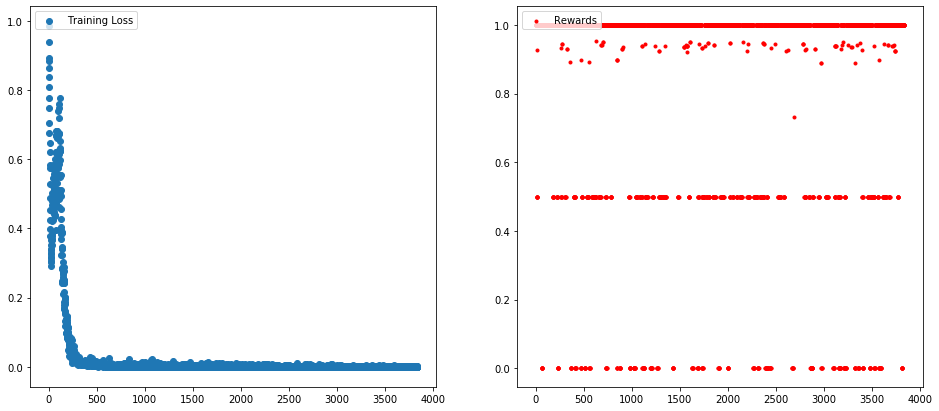

In [16]:
#Gradient Descent RL (TX = TRUE, MS)

loss_history,rewards = Train_RL(with_tx=True,model_type="GD",target_kpi="ms")

pd.DataFrame(loss_history).to_csv('Models/loss_history_{}_{}_{}.csv'.format("tx","GD","ms"), index=False)
pd.DataFrame(rewards).to_csv('Models/rewards_{}_{}_{}.csv'.format("tx","GD","ms"), index=False)

train_data,_ = Dataset(with_tx=True)

print("Lowest Loss: {}, Highest Reward: {}. At Epoch: {} & {}".format(min(loss_history),max(rewards),round(loss_history.index(min(loss_history))/NUMBER_OF_SIM/train_data.shape[0],2),round(rewards.index(max(rewards))/NUMBER_OF_SIM/train_data.shape[0],2)))

plt.figure(1,figsize=(16,7))
plt.subplot(1,2,1)
plt.scatter(range(len(loss_history)),loss_history,label="Training Loss")
plt.legend(loc="upper left")
plt.plot()

plt.subplot(1,2,2)
plt.scatter(range(len(rewards)),rewards,label="Rewards",color='r',marker='.')
plt.legend(loc="upper left")
plt.plot()
plt.show()
    

Epoch: 0/1,Runs: 0/549, Loss: 0.000000, Average Reward: 0.00, Epsilon: 1.0000
Epoch: 0/1,Runs: 1/549, Loss: 0.488067, Average Reward: 0.21, Epsilon: 1.0000
Epoch: 0/1,Runs: 2/549, Loss: 0.489749, Average Reward: 0.40, Epsilon: 1.0000
Epoch: 0/1,Runs: 3/549, Loss: 0.309316, Average Reward: 0.40, Epsilon: 0.9999
Epoch: 0/1,Runs: 4/549, Loss: 0.393774, Average Reward: 0.58, Epsilon: 0.9999
Epoch: 0/1,Runs: 5/549, Loss: 0.420554, Average Reward: 0.55, Epsilon: 0.9999
Epoch: 0/1,Runs: 6/549, Loss: 0.575206, Average Reward: 0.69, Epsilon: 0.9999
Epoch: 0/1,Runs: 7/549, Loss: 0.462929, Average Reward: 0.61, Epsilon: 0.9999
Epoch: 0/1,Runs: 8/549, Loss: 0.577936, Average Reward: 0.64, Epsilon: 0.9998
Epoch: 0/1,Runs: 9/549, Loss: 0.544035, Average Reward: 0.66, Epsilon: 0.9998
Epoch: 0/1,Runs: 10/549, Loss: 0.573887, Average Reward: 0.70, Epsilon: 0.9998
Epoch: 0/1,Runs: 11/549, Loss: 0.622094, Average Reward: 0.71, Epsilon: 0.9998
Epoch: 0/1,Runs: 12/549, Loss: 0.434784, Average Reward: 0.63,

Epoch: 0/1,Runs: 105/549, Loss: 0.004640, Average Reward: 0.75, Epsilon: 0.9979
Epoch: 0/1,Runs: 106/549, Loss: 0.005727, Average Reward: 0.65, Epsilon: 0.9979
Epoch: 0/1,Runs: 107/549, Loss: 0.006966, Average Reward: 0.75, Epsilon: 0.9979
Epoch: 0/1,Runs: 108/549, Loss: 0.001278, Average Reward: 0.76, Epsilon: 0.9979
Epoch: 0/1,Runs: 109/549, Loss: 0.014774, Average Reward: 0.78, Epsilon: 0.9978
Epoch: 0/1,Runs: 110/549, Loss: 0.037413, Average Reward: 0.90, Epsilon: 0.9978
Epoch: 0/1,Runs: 111/549, Loss: 0.007551, Average Reward: 0.78, Epsilon: 0.9978
Epoch: 0/1,Runs: 112/549, Loss: 0.003814, Average Reward: 0.64, Epsilon: 0.9978
Epoch: 0/1,Runs: 113/549, Loss: 0.001893, Average Reward: 0.70, Epsilon: 0.9978
Epoch: 0/1,Runs: 114/549, Loss: 0.003502, Average Reward: 0.72, Epsilon: 0.9977
Epoch: 0/1,Runs: 115/549, Loss: 0.006950, Average Reward: 0.60, Epsilon: 0.9977
Epoch: 0/1,Runs: 116/549, Loss: 0.004716, Average Reward: 0.63, Epsilon: 0.9977
Epoch: 0/1,Runs: 117/549, Loss: 0.004863

Epoch: 0/1,Runs: 208/549, Loss: 0.001091, Average Reward: 0.71, Epsilon: 0.9959
Epoch: 0/1,Runs: 209/549, Loss: 0.003267, Average Reward: 0.61, Epsilon: 0.9959
Epoch: 0/1,Runs: 210/549, Loss: 0.004227, Average Reward: 0.64, Epsilon: 0.9959
Epoch: 0/1,Runs: 211/549, Loss: 0.000726, Average Reward: 0.73, Epsilon: 0.9958
Epoch: 0/1,Runs: 212/549, Loss: 0.000280, Average Reward: 0.71, Epsilon: 0.9958
Epoch: 0/1,Runs: 213/549, Loss: 0.001254, Average Reward: 0.70, Epsilon: 0.9958
Epoch: 0/1,Runs: 214/549, Loss: 0.004711, Average Reward: 0.79, Epsilon: 0.9958
Epoch: 0/1,Runs: 215/549, Loss: 0.000460, Average Reward: 0.71, Epsilon: 0.9958
Epoch: 0/1,Runs: 216/549, Loss: 0.001576, Average Reward: 0.68, Epsilon: 0.9957
Epoch: 0/1,Runs: 217/549, Loss: 0.004740, Average Reward: 0.76, Epsilon: 0.9957
Epoch: 0/1,Runs: 218/549, Loss: 0.000205, Average Reward: 0.69, Epsilon: 0.9957
Epoch: 0/1,Runs: 219/549, Loss: 0.008731, Average Reward: 0.79, Epsilon: 0.9957
Epoch: 0/1,Runs: 220/549, Loss: 0.000824

Epoch: 0/1,Runs: 312/549, Loss: 0.000200, Average Reward: 0.73, Epsilon: 0.9938
Epoch: 0/1,Runs: 313/549, Loss: 0.000101, Average Reward: 0.72, Epsilon: 0.9938
Epoch: 0/1,Runs: 314/549, Loss: 0.006358, Average Reward: 0.59, Epsilon: 0.9938
Epoch: 0/1,Runs: 315/549, Loss: 0.000692, Average Reward: 0.73, Epsilon: 0.9938
Epoch: 0/1,Runs: 316/549, Loss: 0.008899, Average Reward: 0.79, Epsilon: 0.9938
Epoch: 0/1,Runs: 317/549, Loss: 0.000411, Average Reward: 0.72, Epsilon: 0.9937
Epoch: 0/1,Runs: 318/549, Loss: 0.000184, Average Reward: 0.65, Epsilon: 0.9937
Epoch: 0/1,Runs: 319/549, Loss: 0.000088, Average Reward: 0.74, Epsilon: 0.9937
Epoch: 0/1,Runs: 320/549, Loss: 0.001556, Average Reward: 0.59, Epsilon: 0.9937
Epoch: 0/1,Runs: 321/549, Loss: 0.000645, Average Reward: 0.72, Epsilon: 0.9937
Epoch: 0/1,Runs: 322/549, Loss: 0.000229, Average Reward: 0.64, Epsilon: 0.9936
Epoch: 0/1,Runs: 323/549, Loss: 0.000345, Average Reward: 0.69, Epsilon: 0.9936
Epoch: 0/1,Runs: 324/549, Loss: 0.010028

Epoch: 0/1,Runs: 415/549, Loss: 0.000230, Average Reward: 0.69, Epsilon: 0.9918
Epoch: 0/1,Runs: 416/549, Loss: 0.000077, Average Reward: 0.70, Epsilon: 0.9918
Epoch: 0/1,Runs: 417/549, Loss: 0.000183, Average Reward: 0.66, Epsilon: 0.9918
Epoch: 0/1,Runs: 418/549, Loss: 0.000578, Average Reward: 0.74, Epsilon: 0.9918
Epoch: 0/1,Runs: 419/549, Loss: 0.000105, Average Reward: 0.64, Epsilon: 0.9917
Epoch: 0/1,Runs: 420/549, Loss: 0.000174, Average Reward: 0.70, Epsilon: 0.9917
Epoch: 0/1,Runs: 421/549, Loss: 0.000063, Average Reward: 0.68, Epsilon: 0.9917
Epoch: 0/1,Runs: 422/549, Loss: 0.001368, Average Reward: 0.64, Epsilon: 0.9917
Epoch: 0/1,Runs: 423/549, Loss: 0.000514, Average Reward: 0.75, Epsilon: 0.9917
Epoch: 0/1,Runs: 424/549, Loss: 0.000940, Average Reward: 0.72, Epsilon: 0.9916
Epoch: 0/1,Runs: 425/549, Loss: 0.000137, Average Reward: 0.75, Epsilon: 0.9916
Epoch: 0/1,Runs: 426/549, Loss: 0.000689, Average Reward: 0.68, Epsilon: 0.9916
Epoch: 0/1,Runs: 427/549, Loss: 0.001840

Epoch: 0/1,Runs: 518/549, Loss: 0.000826, Average Reward: 0.71, Epsilon: 0.9898
Epoch: 0/1,Runs: 519/549, Loss: 0.002616, Average Reward: 0.65, Epsilon: 0.9898
Epoch: 0/1,Runs: 520/549, Loss: 0.001146, Average Reward: 0.58, Epsilon: 0.9898
Epoch: 0/1,Runs: 521/549, Loss: 0.000214, Average Reward: 0.74, Epsilon: 0.9897
Epoch: 0/1,Runs: 522/549, Loss: 0.000062, Average Reward: 0.73, Epsilon: 0.9897
Epoch: 0/1,Runs: 523/549, Loss: 0.000148, Average Reward: 0.71, Epsilon: 0.9897
Epoch: 0/1,Runs: 524/549, Loss: 0.000055, Average Reward: 0.79, Epsilon: 0.9897
Epoch: 0/1,Runs: 525/549, Loss: 0.000142, Average Reward: 0.73, Epsilon: 0.9897
Epoch: 0/1,Runs: 526/549, Loss: 0.001039, Average Reward: 0.57, Epsilon: 0.9896
Epoch: 0/1,Runs: 527/549, Loss: 0.000109, Average Reward: 0.74, Epsilon: 0.9896
Epoch: 0/1,Runs: 528/549, Loss: 0.000090, Average Reward: 0.72, Epsilon: 0.9896
Epoch: 0/1,Runs: 529/549, Loss: 0.000246, Average Reward: 0.69, Epsilon: 0.9896
Epoch: 0/1,Runs: 530/549, Loss: 0.001036

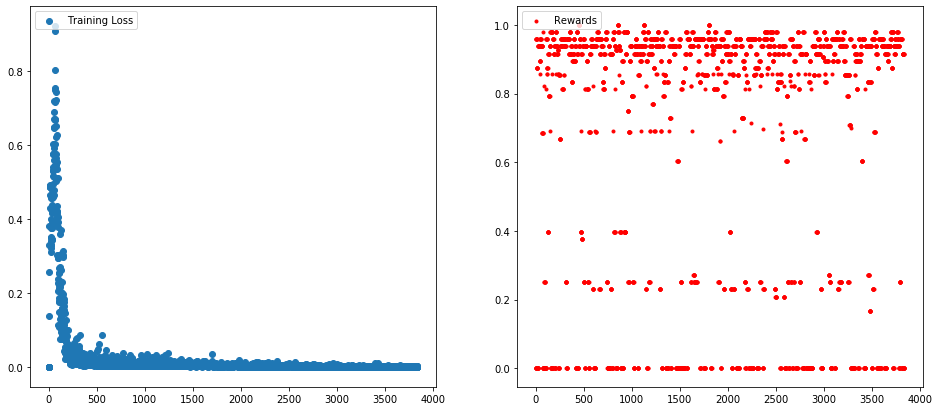

In [17]:
#Gradient Descent RL (TX = TRUE, EC)

loss_history,rewards = Train_RL(with_tx=True,model_type="GD",target_kpi="ec")

pd.DataFrame(loss_history).to_csv('Models/loss_history_{}_{}_{}.csv'.format("tx","GD","ec"), index=False)
pd.DataFrame(rewards).to_csv('Models/rewards_{}_{}_{}.csv'.format("tx","GD","ec"), index=False)

train_data,_ = Dataset(with_tx=True)

print("Lowest Loss: {}, Highest Reward: {}. At Epoch: {} & {}".format(min(loss_history),max(rewards),round(loss_history.index(min(loss_history))/NUMBER_OF_SIM/train_data.shape[0],2),round(rewards.index(max(rewards))/NUMBER_OF_SIM/train_data.shape[0],2)))

plt.figure(1,figsize=(16,7))
plt.subplot(1,2,1)
plt.scatter(range(len(loss_history)),loss_history,label="Training Loss")
plt.legend(loc="upper left")
plt.plot()

plt.subplot(1,2,2)
plt.scatter(range(len(rewards)),rewards,label="Rewards",color='r',marker='.')
plt.legend(loc="upper left")
plt.plot()
plt.show()

Epoch: 0/1,Runs: 0/549, Loss: 0.951237, Average Reward: 0.22, Epsilon: 1.0000
Epoch: 0/1,Runs: 1/549, Loss: 0.453159, Average Reward: 0.22, Epsilon: 1.0000
Epoch: 0/1,Runs: 2/549, Loss: 0.277624, Average Reward: 0.22, Epsilon: 1.0000
Epoch: 0/1,Runs: 3/549, Loss: 0.382637, Average Reward: 0.44, Epsilon: 0.9999
Epoch: 0/1,Runs: 4/549, Loss: 0.284749, Average Reward: 0.38, Epsilon: 0.9999
Epoch: 0/1,Runs: 5/549, Loss: 0.377096, Average Reward: 0.50, Epsilon: 0.9999
Epoch: 0/1,Runs: 6/549, Loss: 0.297346, Average Reward: 0.40, Epsilon: 0.9999
Epoch: 0/1,Runs: 7/549, Loss: 0.476845, Average Reward: 0.47, Epsilon: 0.9999
Epoch: 0/1,Runs: 8/549, Loss: 0.641066, Average Reward: 0.66, Epsilon: 0.9998
Epoch: 0/1,Runs: 9/549, Loss: 0.568647, Average Reward: 0.59, Epsilon: 0.9998
Epoch: 0/1,Runs: 10/549, Loss: 0.876539, Average Reward: 0.50, Epsilon: 0.9998
Epoch: 0/1,Runs: 11/549, Loss: 0.587761, Average Reward: 0.47, Epsilon: 0.9998
Epoch: 0/1,Runs: 12/549, Loss: 0.404134, Average Reward: 0.44,

Epoch: 0/1,Runs: 105/549, Loss: 0.000953, Average Reward: 0.33, Epsilon: 0.9979
Epoch: 0/1,Runs: 106/549, Loss: 0.002924, Average Reward: 0.27, Epsilon: 0.9979
Epoch: 0/1,Runs: 107/549, Loss: 0.003835, Average Reward: 0.36, Epsilon: 0.9979
Epoch: 0/1,Runs: 108/549, Loss: 0.046414, Average Reward: 0.06, Epsilon: 0.9979
Epoch: 0/1,Runs: 109/549, Loss: 0.001097, Average Reward: 0.28, Epsilon: 0.9978
Epoch: 0/1,Runs: 110/549, Loss: 0.003336, Average Reward: 0.27, Epsilon: 0.9978
Epoch: 0/1,Runs: 111/549, Loss: 0.001638, Average Reward: 0.31, Epsilon: 0.9978
Epoch: 0/1,Runs: 112/549, Loss: 0.016836, Average Reward: 0.44, Epsilon: 0.9978
Epoch: 0/1,Runs: 113/549, Loss: 0.003675, Average Reward: 0.22, Epsilon: 0.9978
Epoch: 0/1,Runs: 114/549, Loss: 0.003936, Average Reward: 0.34, Epsilon: 0.9977
Epoch: 0/1,Runs: 115/549, Loss: 0.008734, Average Reward: 0.38, Epsilon: 0.9977
Epoch: 0/1,Runs: 116/549, Loss: 0.003774, Average Reward: 0.33, Epsilon: 0.9977
Epoch: 0/1,Runs: 117/549, Loss: 0.024568

Epoch: 0/1,Runs: 209/549, Loss: 0.017858, Average Reward: 0.09, Epsilon: 0.9959
Epoch: 0/1,Runs: 210/549, Loss: 0.000307, Average Reward: 0.28, Epsilon: 0.9959
Epoch: 0/1,Runs: 211/549, Loss: 0.001803, Average Reward: 0.21, Epsilon: 0.9958
Epoch: 0/1,Runs: 212/549, Loss: 0.004447, Average Reward: 0.37, Epsilon: 0.9958
Epoch: 0/1,Runs: 213/549, Loss: 0.000535, Average Reward: 0.28, Epsilon: 0.9958
Epoch: 0/1,Runs: 214/549, Loss: 0.001137, Average Reward: 0.33, Epsilon: 0.9958
Epoch: 0/1,Runs: 215/549, Loss: 0.013983, Average Reward: 0.16, Epsilon: 0.9958
Epoch: 0/1,Runs: 216/549, Loss: 0.001567, Average Reward: 0.20, Epsilon: 0.9957
Epoch: 0/1,Runs: 217/549, Loss: 0.001847, Average Reward: 0.34, Epsilon: 0.9957
Epoch: 0/1,Runs: 218/549, Loss: 0.032907, Average Reward: 0.52, Epsilon: 0.9957
Epoch: 0/1,Runs: 219/549, Loss: 0.001165, Average Reward: 0.25, Epsilon: 0.9957
Epoch: 0/1,Runs: 220/549, Loss: 0.001702, Average Reward: 0.36, Epsilon: 0.9957
Epoch: 0/1,Runs: 221/549, Loss: 0.005158

Epoch: 0/1,Runs: 312/549, Loss: 0.002805, Average Reward: 0.19, Epsilon: 0.9938
Epoch: 0/1,Runs: 313/549, Loss: 0.007230, Average Reward: 0.44, Epsilon: 0.9938
Epoch: 0/1,Runs: 314/549, Loss: 0.000282, Average Reward: 0.25, Epsilon: 0.9938
Epoch: 0/1,Runs: 315/549, Loss: 0.014161, Average Reward: 0.47, Epsilon: 0.9938
Epoch: 0/1,Runs: 316/549, Loss: 0.004796, Average Reward: 0.37, Epsilon: 0.9938
Epoch: 0/1,Runs: 317/549, Loss: 0.000662, Average Reward: 0.38, Epsilon: 0.9937
Epoch: 0/1,Runs: 318/549, Loss: 0.000529, Average Reward: 0.33, Epsilon: 0.9937
Epoch: 0/1,Runs: 319/549, Loss: 0.008626, Average Reward: 0.16, Epsilon: 0.9937
Epoch: 0/1,Runs: 320/549, Loss: 0.000213, Average Reward: 0.31, Epsilon: 0.9937
Epoch: 0/1,Runs: 321/549, Loss: 0.001876, Average Reward: 0.28, Epsilon: 0.9937
Epoch: 0/1,Runs: 322/549, Loss: 0.003928, Average Reward: 0.22, Epsilon: 0.9936
Epoch: 0/1,Runs: 323/549, Loss: 0.000108, Average Reward: 0.33, Epsilon: 0.9936
Epoch: 0/1,Runs: 324/549, Loss: 0.006056

Epoch: 0/1,Runs: 415/549, Loss: 0.001331, Average Reward: 0.23, Epsilon: 0.9918
Epoch: 0/1,Runs: 416/549, Loss: 0.001231, Average Reward: 0.29, Epsilon: 0.9918
Epoch: 0/1,Runs: 417/549, Loss: 0.000329, Average Reward: 0.34, Epsilon: 0.9918
Epoch: 0/1,Runs: 418/549, Loss: 0.000060, Average Reward: 0.25, Epsilon: 0.9918
Epoch: 0/1,Runs: 419/549, Loss: 0.002403, Average Reward: 0.16, Epsilon: 0.9917
Epoch: 0/1,Runs: 420/549, Loss: 0.003484, Average Reward: 0.47, Epsilon: 0.9917
Epoch: 0/1,Runs: 421/549, Loss: 0.000899, Average Reward: 0.37, Epsilon: 0.9917
Epoch: 0/1,Runs: 422/549, Loss: 0.001705, Average Reward: 0.30, Epsilon: 0.9917
Epoch: 0/1,Runs: 423/549, Loss: 0.002618, Average Reward: 0.34, Epsilon: 0.9917
Epoch: 0/1,Runs: 424/549, Loss: 0.000477, Average Reward: 0.25, Epsilon: 0.9916
Epoch: 0/1,Runs: 425/549, Loss: 0.003609, Average Reward: 0.32, Epsilon: 0.9916
Epoch: 0/1,Runs: 426/549, Loss: 0.001861, Average Reward: 0.34, Epsilon: 0.9916
Epoch: 0/1,Runs: 427/549, Loss: 0.000382

Epoch: 0/1,Runs: 518/549, Loss: 0.000123, Average Reward: 0.23, Epsilon: 0.9898
Epoch: 0/1,Runs: 519/549, Loss: 0.000373, Average Reward: 0.22, Epsilon: 0.9898
Epoch: 0/1,Runs: 520/549, Loss: 0.000077, Average Reward: 0.21, Epsilon: 0.9898
Epoch: 0/1,Runs: 521/549, Loss: 0.001370, Average Reward: 0.19, Epsilon: 0.9897
Epoch: 0/1,Runs: 522/549, Loss: 0.000181, Average Reward: 0.37, Epsilon: 0.9897
Epoch: 0/1,Runs: 523/549, Loss: 0.000424, Average Reward: 0.22, Epsilon: 0.9897
Epoch: 0/1,Runs: 524/549, Loss: 0.001414, Average Reward: 0.36, Epsilon: 0.9897
Epoch: 0/1,Runs: 525/549, Loss: 0.000542, Average Reward: 0.27, Epsilon: 0.9897
Epoch: 0/1,Runs: 526/549, Loss: 0.000097, Average Reward: 0.19, Epsilon: 0.9896
Epoch: 0/1,Runs: 527/549, Loss: 0.000394, Average Reward: 0.30, Epsilon: 0.9896
Epoch: 0/1,Runs: 528/549, Loss: 0.001590, Average Reward: 0.23, Epsilon: 0.9896
Epoch: 0/1,Runs: 529/549, Loss: 0.000480, Average Reward: 0.30, Epsilon: 0.9896
Epoch: 0/1,Runs: 530/549, Loss: 0.001218

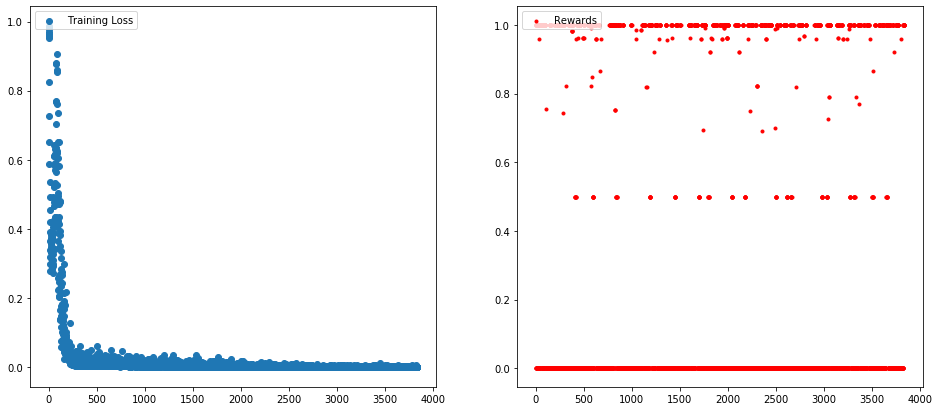

In [18]:
#Gradient Descent RL (TX = TRUE, TP)

loss_history,rewards = Train_RL(with_tx=True,model_type="GD",target_kpi="tp")

pd.DataFrame(loss_history).to_csv('Models/loss_history_{}_{}_{}.csv'.format("tx","GD","tp"), index=False)
pd.DataFrame(rewards).to_csv('Models/rewards_{}_{}_{}.csv'.format("tx","GD","tp"), index=False)

train_data,_ = Dataset(with_tx=True)

print("Lowest Loss: {}, Highest Reward: {}. At Epoch: {} & {}".format(min(loss_history),max(rewards),round(loss_history.index(min(loss_history))/NUMBER_OF_SIM/train_data.shape[0],2),round(rewards.index(max(rewards))/NUMBER_OF_SIM/train_data.shape[0],2)))

plt.figure(1,figsize=(16,7))
plt.subplot(1,2,1)
plt.scatter(range(len(loss_history)),loss_history,label="Training Loss")
plt.legend(loc="upper left")
plt.plot()

plt.subplot(1,2,2)
plt.scatter(range(len(rewards)),rewards,label="Rewards",color='r',marker='.')
plt.legend(loc="upper left")
plt.plot()
plt.show()

Epoch: 0/1,Runs: 0/549, Loss: 0.517103, Average Reward: 0.16, Epsilon: 1.0000
Epoch: 0/1,Runs: 1/549, Loss: 0.592657, Average Reward: 0.35, Epsilon: 1.0000
Epoch: 0/1,Runs: 2/549, Loss: 0.784230, Average Reward: 0.54, Epsilon: 1.0000
Epoch: 0/1,Runs: 3/549, Loss: 0.880101, Average Reward: 0.73, Epsilon: 0.9999
Epoch: 0/1,Runs: 4/549, Loss: 0.885536, Average Reward: 0.84, Epsilon: 0.9999
Epoch: 0/1,Runs: 5/549, Loss: 1.061337, Average Reward: 0.84, Epsilon: 0.9999
Epoch: 0/1,Runs: 6/549, Loss: 1.056157, Average Reward: 0.85, Epsilon: 0.9999
Epoch: 0/1,Runs: 7/549, Loss: 0.995354, Average Reward: 0.86, Epsilon: 0.9999
Epoch: 0/1,Runs: 8/549, Loss: 1.081072, Average Reward: 0.86, Epsilon: 0.9998
Epoch: 0/1,Runs: 9/549, Loss: 0.744174, Average Reward: 0.78, Epsilon: 0.9998
Epoch: 0/1,Runs: 10/549, Loss: 0.762018, Average Reward: 0.82, Epsilon: 0.9998
Epoch: 0/1,Runs: 11/549, Loss: 0.435301, Average Reward: 0.83, Epsilon: 0.9998
Epoch: 0/1,Runs: 12/549, Loss: 0.522093, Average Reward: 0.81,

Epoch: 0/1,Runs: 104/549, Loss: 0.000410, Average Reward: 0.63, Epsilon: 0.9979
Epoch: 0/1,Runs: 105/549, Loss: 0.000652, Average Reward: 0.66, Epsilon: 0.9979
Epoch: 0/1,Runs: 106/549, Loss: 0.001462, Average Reward: 0.64, Epsilon: 0.9979
Epoch: 0/1,Runs: 107/549, Loss: 0.000721, Average Reward: 0.65, Epsilon: 0.9979
Epoch: 0/1,Runs: 108/549, Loss: 0.004475, Average Reward: 0.60, Epsilon: 0.9979
Epoch: 0/1,Runs: 109/549, Loss: 0.001287, Average Reward: 0.64, Epsilon: 0.9978
Epoch: 0/1,Runs: 110/549, Loss: 0.001161, Average Reward: 0.71, Epsilon: 0.9978
Epoch: 0/1,Runs: 111/549, Loss: 0.001743, Average Reward: 0.71, Epsilon: 0.9978
Epoch: 0/1,Runs: 112/549, Loss: 0.001266, Average Reward: 0.71, Epsilon: 0.9978
Epoch: 0/1,Runs: 113/549, Loss: 0.006418, Average Reward: 0.55, Epsilon: 0.9978
Epoch: 0/1,Runs: 114/549, Loss: 0.000374, Average Reward: 0.68, Epsilon: 0.9977
Epoch: 0/1,Runs: 115/549, Loss: 0.002382, Average Reward: 0.60, Epsilon: 0.9977
Epoch: 0/1,Runs: 116/549, Loss: 0.000448

Epoch: 0/1,Runs: 207/549, Loss: 0.000081, Average Reward: 0.66, Epsilon: 0.9959
Epoch: 0/1,Runs: 208/549, Loss: 0.001328, Average Reward: 0.73, Epsilon: 0.9959
Epoch: 0/1,Runs: 209/549, Loss: 0.000098, Average Reward: 0.73, Epsilon: 0.9959
Epoch: 0/1,Runs: 210/549, Loss: 0.000166, Average Reward: 0.65, Epsilon: 0.9959
Epoch: 0/1,Runs: 211/549, Loss: 0.000860, Average Reward: 0.73, Epsilon: 0.9958
Epoch: 0/1,Runs: 212/549, Loss: 0.000971, Average Reward: 0.63, Epsilon: 0.9958
Epoch: 0/1,Runs: 213/549, Loss: 0.000284, Average Reward: 0.62, Epsilon: 0.9958
Epoch: 0/1,Runs: 214/549, Loss: 0.000826, Average Reward: 0.64, Epsilon: 0.9958
Epoch: 0/1,Runs: 215/549, Loss: 0.000455, Average Reward: 0.64, Epsilon: 0.9958
Epoch: 0/1,Runs: 216/549, Loss: 0.003339, Average Reward: 0.71, Epsilon: 0.9957
Epoch: 0/1,Runs: 217/549, Loss: 0.000459, Average Reward: 0.68, Epsilon: 0.9957
Epoch: 0/1,Runs: 218/549, Loss: 0.000132, Average Reward: 0.65, Epsilon: 0.9957
Epoch: 0/1,Runs: 219/549, Loss: 0.000571

Epoch: 0/1,Runs: 310/549, Loss: 0.000533, Average Reward: 0.57, Epsilon: 0.9939
Epoch: 0/1,Runs: 311/549, Loss: 0.000389, Average Reward: 0.66, Epsilon: 0.9939
Epoch: 0/1,Runs: 312/549, Loss: 0.000315, Average Reward: 0.67, Epsilon: 0.9938
Epoch: 0/1,Runs: 313/549, Loss: 0.001435, Average Reward: 0.71, Epsilon: 0.9938
Epoch: 0/1,Runs: 314/549, Loss: 0.000373, Average Reward: 0.74, Epsilon: 0.9938
Epoch: 0/1,Runs: 315/549, Loss: 0.000513, Average Reward: 0.65, Epsilon: 0.9938
Epoch: 0/1,Runs: 316/549, Loss: 0.000091, Average Reward: 0.67, Epsilon: 0.9938
Epoch: 0/1,Runs: 317/549, Loss: 0.001507, Average Reward: 0.59, Epsilon: 0.9937
Epoch: 0/1,Runs: 318/549, Loss: 0.000331, Average Reward: 0.69, Epsilon: 0.9937
Epoch: 0/1,Runs: 319/549, Loss: 0.000201, Average Reward: 0.69, Epsilon: 0.9937
Epoch: 0/1,Runs: 320/549, Loss: 0.002456, Average Reward: 0.76, Epsilon: 0.9937
Epoch: 0/1,Runs: 321/549, Loss: 0.000055, Average Reward: 0.67, Epsilon: 0.9937
Epoch: 0/1,Runs: 322/549, Loss: 0.000096

Epoch: 0/1,Runs: 413/549, Loss: 0.000094, Average Reward: 0.66, Epsilon: 0.9919
Epoch: 0/1,Runs: 414/549, Loss: 0.000086, Average Reward: 0.62, Epsilon: 0.9918
Epoch: 0/1,Runs: 415/549, Loss: 0.000785, Average Reward: 0.55, Epsilon: 0.9918
Epoch: 0/1,Runs: 416/549, Loss: 0.000052, Average Reward: 0.67, Epsilon: 0.9918
Epoch: 0/1,Runs: 417/549, Loss: 0.000563, Average Reward: 0.71, Epsilon: 0.9918
Epoch: 0/1,Runs: 418/549, Loss: 0.000094, Average Reward: 0.63, Epsilon: 0.9918
Epoch: 0/1,Runs: 419/549, Loss: 0.000326, Average Reward: 0.67, Epsilon: 0.9917
Epoch: 0/1,Runs: 420/549, Loss: 0.000251, Average Reward: 0.65, Epsilon: 0.9917
Epoch: 0/1,Runs: 421/549, Loss: 0.000058, Average Reward: 0.69, Epsilon: 0.9917
Epoch: 0/1,Runs: 422/549, Loss: 0.000186, Average Reward: 0.65, Epsilon: 0.9917
Epoch: 0/1,Runs: 423/549, Loss: 0.000136, Average Reward: 0.71, Epsilon: 0.9917
Epoch: 0/1,Runs: 424/549, Loss: 0.000154, Average Reward: 0.59, Epsilon: 0.9916
Epoch: 0/1,Runs: 425/549, Loss: 0.000030

Epoch: 0/1,Runs: 516/549, Loss: 0.000220, Average Reward: 0.66, Epsilon: 0.9898
Epoch: 0/1,Runs: 517/549, Loss: 0.000017, Average Reward: 0.67, Epsilon: 0.9898
Epoch: 0/1,Runs: 518/549, Loss: 0.000061, Average Reward: 0.73, Epsilon: 0.9898
Epoch: 0/1,Runs: 519/549, Loss: 0.000026, Average Reward: 0.69, Epsilon: 0.9898
Epoch: 0/1,Runs: 520/549, Loss: 0.000045, Average Reward: 0.70, Epsilon: 0.9898
Epoch: 0/1,Runs: 521/549, Loss: 0.000010, Average Reward: 0.69, Epsilon: 0.9897
Epoch: 0/1,Runs: 522/549, Loss: 0.000024, Average Reward: 0.71, Epsilon: 0.9897
Epoch: 0/1,Runs: 523/549, Loss: 0.000379, Average Reward: 0.58, Epsilon: 0.9897
Epoch: 0/1,Runs: 524/549, Loss: 0.000022, Average Reward: 0.69, Epsilon: 0.9897
Epoch: 0/1,Runs: 525/549, Loss: 0.000225, Average Reward: 0.65, Epsilon: 0.9897
Epoch: 0/1,Runs: 526/549, Loss: 0.000017, Average Reward: 0.69, Epsilon: 0.9896
Epoch: 0/1,Runs: 527/549, Loss: 0.000266, Average Reward: 0.62, Epsilon: 0.9896
Epoch: 0/1,Runs: 528/549, Loss: 0.000157

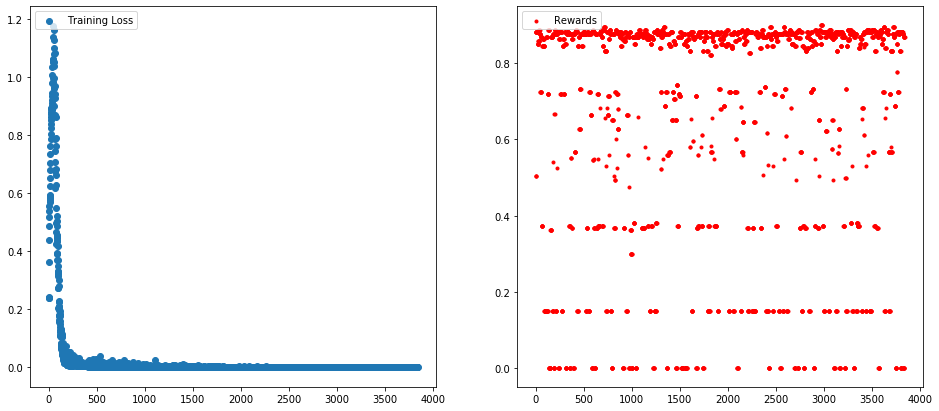

In [19]:
#Gradient Descent RL (TX = TRUE, Combination)

loss_history,rewards = Train_RL(with_tx=True,model_type="GD",target_kpi="all")

pd.DataFrame(loss_history).to_csv('Models/loss_history_{}_{}_{}.csv'.format("tx","GD","all"), index=False)
pd.DataFrame(rewards).to_csv('Models/rewards_{}_{}_{}.csv'.format("tx","GD","all"), index=False)

train_data,_ = Dataset(with_tx=True)

print("Lowest Loss: {}, Highest Reward: {}. At Epoch: {} & {}".format(min(loss_history),max(rewards),round(loss_history.index(min(loss_history))/NUMBER_OF_SIM/train_data.shape[0],2),round(rewards.index(max(rewards))/NUMBER_OF_SIM/train_data.shape[0],2)))

plt.figure(1,figsize=(16,7))
plt.subplot(1,2,1)
plt.scatter(range(len(loss_history)),loss_history,label="Training Loss")
plt.legend(loc="upper left")
plt.plot()

plt.subplot(1,2,2)
plt.scatter(range(len(rewards)),rewards,label="Rewards",color='r',marker='.')
plt.legend(loc="upper left")
plt.plot()
plt.show()

In [20]:
#Gradient Descent RL (TX=FALSE, MS)

loss_history,rewards = Train_RL(with_tx=False,model_type="GD",target_kpi="ms")

pd.DataFrame(loss_history).to_csv('Models/loss_history_{}_{}_{}.csv'.format("no_tx","GD","ms"), index=False)
pd.DataFrame(rewards).to_csv('Models/rewards_{}_{}_{}.csv'.format("no_tx","GD","ms"), index=False)

train_data,_ = Dataset(with_tx=True)

print("Lowest Loss: {}, Highest Reward: {}. At Epoch: {} & {}".format(min(loss_history),max(rewards),round(loss_history.index(min(loss_history))/NUMBER_OF_SIM/train_data.shape[0],2),round(rewards.index(max(rewards))/NUMBER_OF_SIM/train_data.shape[0],2)))

plt.figure(1,figsize=(16,7))
plt.subplot(1,2,1)
plt.scatter(range(len(loss_history)),loss_history,label="Training Loss")
plt.legend(loc="upper left")
plt.plot()

plt.subplot(1,2,2)
plt.scatter(range(len(rewards)),rewards,label="Rewards",color='r',marker='.')
plt.legend(loc="upper left")
plt.plot()
plt.show()

Epoch: 0/1,Runs: 0/7789, Loss: 0.860670, Average Reward: 0.22, Epsilon: 1.0000
Epoch: 0/1,Runs: 1/7789, Loss: 0.838311, Average Reward: 0.44, Epsilon: 1.0000
Epoch: 0/1,Runs: 2/7789, Loss: 0.769623, Average Reward: 0.66, Epsilon: 1.0000
Epoch: 0/1,Runs: 3/7789, Loss: 0.603726, Average Reward: 0.88, Epsilon: 0.9999
Epoch: 0/1,Runs: 4/7789, Loss: 0.477444, Average Reward: 1.00, Epsilon: 0.9999
Epoch: 0/1,Runs: 5/7789, Loss: 0.361134, Average Reward: 0.84, Epsilon: 0.9999
Epoch: 0/1,Runs: 6/7789, Loss: 0.295696, Average Reward: 0.75, Epsilon: 0.9999
Epoch: 0/1,Runs: 7/7789, Loss: 0.227088, Average Reward: 0.66, Epsilon: 0.9999
Epoch: 0/1,Runs: 8/7789, Loss: 0.165453, Average Reward: 0.64, Epsilon: 0.9998
Epoch: 0/1,Runs: 9/7789, Loss: 0.103502, Average Reward: 0.52, Epsilon: 0.9998
Epoch: 0/1,Runs: 10/7789, Loss: 0.202034, Average Reward: 0.66, Epsilon: 0.9998
Epoch: 0/1,Runs: 11/7789, Loss: 0.201383, Average Reward: 0.66, Epsilon: 0.9998
Epoch: 0/1,Runs: 12/7789, Loss: 0.180396, Average 

Epoch: 0/1,Runs: 103/7789, Loss: 0.010961, Average Reward: 0.33, Epsilon: 0.9980
Epoch: 0/1,Runs: 104/7789, Loss: 0.007211, Average Reward: 0.34, Epsilon: 0.9979
Epoch: 0/1,Runs: 105/7789, Loss: 0.006572, Average Reward: 0.50, Epsilon: 0.9979
Epoch: 0/1,Runs: 106/7789, Loss: 0.000544, Average Reward: 0.44, Epsilon: 0.9979
Epoch: 0/1,Runs: 107/7789, Loss: 0.001442, Average Reward: 0.45, Epsilon: 0.9979
Epoch: 0/1,Runs: 108/7789, Loss: 0.000210, Average Reward: 0.41, Epsilon: 0.9979
Epoch: 0/1,Runs: 109/7789, Loss: 0.004988, Average Reward: 0.34, Epsilon: 0.9978
Epoch: 0/1,Runs: 110/7789, Loss: 0.001649, Average Reward: 0.39, Epsilon: 0.9978
Epoch: 0/1,Runs: 111/7789, Loss: 0.000339, Average Reward: 0.43, Epsilon: 0.9978
Epoch: 0/1,Runs: 112/7789, Loss: 0.000556, Average Reward: 0.42, Epsilon: 0.9978
Epoch: 0/1,Runs: 113/7789, Loss: 0.004634, Average Reward: 0.48, Epsilon: 0.9978
Epoch: 0/1,Runs: 114/7789, Loss: 0.001952, Average Reward: 0.34, Epsilon: 0.9977
Epoch: 0/1,Runs: 115/7789, L

Epoch: 0/1,Runs: 205/7789, Loss: 0.007925, Average Reward: 0.28, Epsilon: 0.9959
Epoch: 0/1,Runs: 206/7789, Loss: 0.003130, Average Reward: 0.31, Epsilon: 0.9959
Epoch: 0/1,Runs: 207/7789, Loss: 0.001362, Average Reward: 0.39, Epsilon: 0.9959
Epoch: 0/1,Runs: 208/7789, Loss: 0.005816, Average Reward: 0.45, Epsilon: 0.9959
Epoch: 0/1,Runs: 209/7789, Loss: 0.000144, Average Reward: 0.36, Epsilon: 0.9959
Epoch: 0/1,Runs: 210/7789, Loss: 0.000089, Average Reward: 0.34, Epsilon: 0.9959
Epoch: 0/1,Runs: 211/7789, Loss: 0.000473, Average Reward: 0.39, Epsilon: 0.9958
Epoch: 0/1,Runs: 212/7789, Loss: 0.003227, Average Reward: 0.30, Epsilon: 0.9958
Epoch: 0/1,Runs: 213/7789, Loss: 0.005317, Average Reward: 0.30, Epsilon: 0.9958
Epoch: 0/1,Runs: 214/7789, Loss: 0.003879, Average Reward: 0.45, Epsilon: 0.9958
Epoch: 0/1,Runs: 215/7789, Loss: 0.024757, Average Reward: 0.56, Epsilon: 0.9958
Epoch: 0/1,Runs: 216/7789, Loss: 0.013825, Average Reward: 0.25, Epsilon: 0.9957
Epoch: 0/1,Runs: 217/7789, L

Epoch: 0/1,Runs: 307/7789, Loss: 0.000441, Average Reward: 0.34, Epsilon: 0.9939
Epoch: 0/1,Runs: 308/7789, Loss: 0.000295, Average Reward: 0.44, Epsilon: 0.9939
Epoch: 0/1,Runs: 309/7789, Loss: 0.002600, Average Reward: 0.43, Epsilon: 0.9939
Epoch: 0/1,Runs: 310/7789, Loss: 0.002463, Average Reward: 0.30, Epsilon: 0.9939
Epoch: 0/1,Runs: 311/7789, Loss: 0.000490, Average Reward: 0.35, Epsilon: 0.9939
Epoch: 0/1,Runs: 312/7789, Loss: 0.001020, Average Reward: 0.41, Epsilon: 0.9938
Epoch: 0/1,Runs: 313/7789, Loss: 0.000153, Average Reward: 0.41, Epsilon: 0.9938
Epoch: 0/1,Runs: 314/7789, Loss: 0.000147, Average Reward: 0.33, Epsilon: 0.9938
Epoch: 0/1,Runs: 315/7789, Loss: 0.000502, Average Reward: 0.39, Epsilon: 0.9938
Epoch: 0/1,Runs: 316/7789, Loss: 0.000115, Average Reward: 0.40, Epsilon: 0.9938
Epoch: 0/1,Runs: 317/7789, Loss: 0.020966, Average Reward: 0.16, Epsilon: 0.9937
Epoch: 0/1,Runs: 318/7789, Loss: 0.000480, Average Reward: 0.39, Epsilon: 0.9937
Epoch: 0/1,Runs: 319/7789, L

Epoch: 0/1,Runs: 409/7789, Loss: 0.001735, Average Reward: 0.30, Epsilon: 0.9919
Epoch: 0/1,Runs: 410/7789, Loss: 0.001265, Average Reward: 0.44, Epsilon: 0.9919
Epoch: 0/1,Runs: 411/7789, Loss: 0.000285, Average Reward: 0.31, Epsilon: 0.9919
Epoch: 0/1,Runs: 412/7789, Loss: 0.002976, Average Reward: 0.25, Epsilon: 0.9919
Epoch: 0/1,Runs: 413/7789, Loss: 0.003086, Average Reward: 0.52, Epsilon: 0.9919
Epoch: 0/1,Runs: 414/7789, Loss: 0.000105, Average Reward: 0.39, Epsilon: 0.9918
Epoch: 0/1,Runs: 415/7789, Loss: 0.001414, Average Reward: 0.48, Epsilon: 0.9918
Epoch: 0/1,Runs: 416/7789, Loss: 0.000244, Average Reward: 0.31, Epsilon: 0.9918
Epoch: 0/1,Runs: 417/7789, Loss: 0.000739, Average Reward: 0.41, Epsilon: 0.9918
Epoch: 0/1,Runs: 418/7789, Loss: 0.000648, Average Reward: 0.31, Epsilon: 0.9918
Epoch: 0/1,Runs: 419/7789, Loss: 0.003890, Average Reward: 0.59, Epsilon: 0.9917
Epoch: 0/1,Runs: 420/7789, Loss: 0.000075, Average Reward: 0.33, Epsilon: 0.9917
Epoch: 0/1,Runs: 421/7789, L

Epoch: 0/1,Runs: 511/7789, Loss: 0.000032, Average Reward: 0.36, Epsilon: 0.9899
Epoch: 0/1,Runs: 512/7789, Loss: 0.000124, Average Reward: 0.33, Epsilon: 0.9899
Epoch: 0/1,Runs: 513/7789, Loss: 0.000689, Average Reward: 0.33, Epsilon: 0.9899
Epoch: 0/1,Runs: 514/7789, Loss: 0.002249, Average Reward: 0.42, Epsilon: 0.9899
Epoch: 0/1,Runs: 515/7789, Loss: 0.001074, Average Reward: 0.44, Epsilon: 0.9899
Epoch: 0/1,Runs: 516/7789, Loss: 0.000111, Average Reward: 0.38, Epsilon: 0.9898
Epoch: 0/1,Runs: 517/7789, Loss: 0.000091, Average Reward: 0.47, Epsilon: 0.9898
Epoch: 0/1,Runs: 518/7789, Loss: 0.000048, Average Reward: 0.42, Epsilon: 0.9898
Epoch: 0/1,Runs: 519/7789, Loss: 0.000042, Average Reward: 0.55, Epsilon: 0.9898
Epoch: 0/1,Runs: 520/7789, Loss: 0.000129, Average Reward: 0.39, Epsilon: 0.9898
Epoch: 0/1,Runs: 521/7789, Loss: 0.001278, Average Reward: 0.34, Epsilon: 0.9897
Epoch: 0/1,Runs: 522/7789, Loss: 0.000022, Average Reward: 0.41, Epsilon: 0.9897
Epoch: 0/1,Runs: 523/7789, L

Epoch: 0/1,Runs: 614/7789, Loss: 0.000736, Average Reward: 0.25, Epsilon: 0.9879
Epoch: 0/1,Runs: 615/7789, Loss: 0.000036, Average Reward: 0.52, Epsilon: 0.9879
Epoch: 0/1,Runs: 616/7789, Loss: 0.000024, Average Reward: 0.37, Epsilon: 0.9879
Epoch: 0/1,Runs: 617/7789, Loss: 0.000046, Average Reward: 0.40, Epsilon: 0.9879
Epoch: 0/1,Runs: 618/7789, Loss: 0.000032, Average Reward: 0.28, Epsilon: 0.9878
Epoch: 0/1,Runs: 619/7789, Loss: 0.000028, Average Reward: 0.38, Epsilon: 0.9878
Epoch: 0/1,Runs: 620/7789, Loss: 0.000149, Average Reward: 0.42, Epsilon: 0.9878
Epoch: 0/1,Runs: 621/7789, Loss: 0.000169, Average Reward: 0.42, Epsilon: 0.9878
Epoch: 0/1,Runs: 622/7789, Loss: 0.000097, Average Reward: 0.37, Epsilon: 0.9878
Epoch: 0/1,Runs: 623/7789, Loss: 0.000028, Average Reward: 0.52, Epsilon: 0.9877
Epoch: 0/1,Runs: 624/7789, Loss: 0.000055, Average Reward: 0.37, Epsilon: 0.9877
Epoch: 0/1,Runs: 625/7789, Loss: 0.000120, Average Reward: 0.50, Epsilon: 0.9877
Epoch: 0/1,Runs: 626/7789, L

Epoch: 0/1,Runs: 716/7789, Loss: 0.000669, Average Reward: 0.50, Epsilon: 0.9859
Epoch: 0/1,Runs: 717/7789, Loss: 0.000051, Average Reward: 0.34, Epsilon: 0.9859
Epoch: 0/1,Runs: 718/7789, Loss: 0.000106, Average Reward: 0.34, Epsilon: 0.9859
Epoch: 0/1,Runs: 719/7789, Loss: 0.000101, Average Reward: 0.28, Epsilon: 0.9859
Epoch: 0/1,Runs: 720/7789, Loss: 0.000094, Average Reward: 0.47, Epsilon: 0.9858
Epoch: 0/1,Runs: 721/7789, Loss: 0.000107, Average Reward: 0.42, Epsilon: 0.9858
Epoch: 0/1,Runs: 722/7789, Loss: 0.000159, Average Reward: 0.39, Epsilon: 0.9858
Epoch: 0/1,Runs: 723/7789, Loss: 0.001603, Average Reward: 0.37, Epsilon: 0.9858
Epoch: 0/1,Runs: 724/7789, Loss: 0.000558, Average Reward: 0.55, Epsilon: 0.9858
Epoch: 0/1,Runs: 725/7789, Loss: 0.000239, Average Reward: 0.36, Epsilon: 0.9857
Epoch: 0/1,Runs: 726/7789, Loss: 0.000169, Average Reward: 0.45, Epsilon: 0.9857
Epoch: 0/1,Runs: 727/7789, Loss: 0.000056, Average Reward: 0.48, Epsilon: 0.9857
Epoch: 0/1,Runs: 728/7789, L

Epoch: 0/1,Runs: 819/7789, Loss: 0.000233, Average Reward: 0.45, Epsilon: 0.9839
Epoch: 0/1,Runs: 820/7789, Loss: 0.000051, Average Reward: 0.34, Epsilon: 0.9839
Epoch: 0/1,Runs: 821/7789, Loss: 0.000024, Average Reward: 0.45, Epsilon: 0.9839
Epoch: 0/1,Runs: 822/7789, Loss: 0.000166, Average Reward: 0.56, Epsilon: 0.9839
Epoch: 0/1,Runs: 823/7789, Loss: 0.000205, Average Reward: 0.39, Epsilon: 0.9838
Epoch: 0/1,Runs: 824/7789, Loss: 0.000031, Average Reward: 0.38, Epsilon: 0.9838
Epoch: 0/1,Runs: 825/7789, Loss: 0.000043, Average Reward: 0.49, Epsilon: 0.9838
Epoch: 0/1,Runs: 826/7789, Loss: 0.000025, Average Reward: 0.39, Epsilon: 0.9838
Epoch: 0/1,Runs: 827/7789, Loss: 0.000052, Average Reward: 0.36, Epsilon: 0.9838
Epoch: 0/1,Runs: 828/7789, Loss: 0.000070, Average Reward: 0.42, Epsilon: 0.9837
Epoch: 0/1,Runs: 829/7789, Loss: 0.000121, Average Reward: 0.39, Epsilon: 0.9837
Epoch: 0/1,Runs: 830/7789, Loss: 0.000498, Average Reward: 0.38, Epsilon: 0.9837
Epoch: 0/1,Runs: 831/7789, L

Epoch: 0/1,Runs: 921/7789, Loss: 0.000076, Average Reward: 0.45, Epsilon: 0.9819
Epoch: 0/1,Runs: 922/7789, Loss: 0.000228, Average Reward: 0.41, Epsilon: 0.9819
Epoch: 0/1,Runs: 923/7789, Loss: 0.000036, Average Reward: 0.48, Epsilon: 0.9819
Epoch: 0/1,Runs: 924/7789, Loss: 0.000048, Average Reward: 0.33, Epsilon: 0.9819
Epoch: 0/1,Runs: 925/7789, Loss: 0.000020, Average Reward: 0.48, Epsilon: 0.9819
Epoch: 0/1,Runs: 926/7789, Loss: 0.000239, Average Reward: 0.45, Epsilon: 0.9818
Epoch: 0/1,Runs: 927/7789, Loss: 0.000041, Average Reward: 0.58, Epsilon: 0.9818
Epoch: 0/1,Runs: 928/7789, Loss: 0.000046, Average Reward: 0.34, Epsilon: 0.9818
Epoch: 0/1,Runs: 929/7789, Loss: 0.000073, Average Reward: 0.52, Epsilon: 0.9818
Epoch: 0/1,Runs: 930/7789, Loss: 0.000015, Average Reward: 0.39, Epsilon: 0.9818
Epoch: 0/1,Runs: 931/7789, Loss: 0.000252, Average Reward: 0.30, Epsilon: 0.9817
Epoch: 0/1,Runs: 932/7789, Loss: 0.000030, Average Reward: 0.42, Epsilon: 0.9817
Epoch: 0/1,Runs: 933/7789, L

Epoch: 0/1,Runs: 1022/7789, Loss: 0.000406, Average Reward: 0.47, Epsilon: 0.9800
Epoch: 0/1,Runs: 1023/7789, Loss: 0.000026, Average Reward: 0.44, Epsilon: 0.9800
Epoch: 0/1,Runs: 1024/7789, Loss: 0.000054, Average Reward: 0.44, Epsilon: 0.9799
Epoch: 0/1,Runs: 1025/7789, Loss: 0.000032, Average Reward: 0.36, Epsilon: 0.9799
Epoch: 0/1,Runs: 1026/7789, Loss: 0.000622, Average Reward: 0.48, Epsilon: 0.9799
Epoch: 0/1,Runs: 1027/7789, Loss: 0.000222, Average Reward: 0.37, Epsilon: 0.9799
Epoch: 0/1,Runs: 1028/7789, Loss: 0.000091, Average Reward: 0.43, Epsilon: 0.9799
Epoch: 0/1,Runs: 1029/7789, Loss: 0.000077, Average Reward: 0.39, Epsilon: 0.9798
Epoch: 0/1,Runs: 1030/7789, Loss: 0.000461, Average Reward: 0.39, Epsilon: 0.9798
Epoch: 0/1,Runs: 1031/7789, Loss: 0.000322, Average Reward: 0.52, Epsilon: 0.9798
Epoch: 0/1,Runs: 1032/7789, Loss: 0.000324, Average Reward: 0.27, Epsilon: 0.9798
Epoch: 0/1,Runs: 1033/7789, Loss: 0.000028, Average Reward: 0.36, Epsilon: 0.9798
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 1122/7789, Loss: 0.000035, Average Reward: 0.45, Epsilon: 0.9780
Epoch: 0/1,Runs: 1123/7789, Loss: 0.000051, Average Reward: 0.48, Epsilon: 0.9780
Epoch: 0/1,Runs: 1124/7789, Loss: 0.000061, Average Reward: 0.41, Epsilon: 0.9780
Epoch: 0/1,Runs: 1125/7789, Loss: 0.000013, Average Reward: 0.28, Epsilon: 0.9780
Epoch: 0/1,Runs: 1126/7789, Loss: 0.000028, Average Reward: 0.47, Epsilon: 0.9780
Epoch: 0/1,Runs: 1127/7789, Loss: 0.000053, Average Reward: 0.44, Epsilon: 0.9779
Epoch: 0/1,Runs: 1128/7789, Loss: 0.000034, Average Reward: 0.39, Epsilon: 0.9779
Epoch: 0/1,Runs: 1129/7789, Loss: 0.000103, Average Reward: 0.31, Epsilon: 0.9779
Epoch: 0/1,Runs: 1130/7789, Loss: 0.000015, Average Reward: 0.31, Epsilon: 0.9779
Epoch: 0/1,Runs: 1131/7789, Loss: 0.000221, Average Reward: 0.59, Epsilon: 0.9779
Epoch: 0/1,Runs: 1132/7789, Loss: 0.000058, Average Reward: 0.47, Epsilon: 0.9778
Epoch: 0/1,Runs: 1133/7789, Loss: 0.000033, Average Reward: 0.44, Epsilon: 0.9778
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 1222/7789, Loss: 0.000067, Average Reward: 0.34, Epsilon: 0.9761
Epoch: 0/1,Runs: 1223/7789, Loss: 0.000112, Average Reward: 0.39, Epsilon: 0.9761
Epoch: 0/1,Runs: 1224/7789, Loss: 0.000157, Average Reward: 0.39, Epsilon: 0.9761
Epoch: 0/1,Runs: 1225/7789, Loss: 0.000127, Average Reward: 0.51, Epsilon: 0.9760
Epoch: 0/1,Runs: 1226/7789, Loss: 0.000038, Average Reward: 0.48, Epsilon: 0.9760
Epoch: 0/1,Runs: 1227/7789, Loss: 0.000077, Average Reward: 0.50, Epsilon: 0.9760
Epoch: 0/1,Runs: 1228/7789, Loss: 0.000157, Average Reward: 0.34, Epsilon: 0.9760
Epoch: 0/1,Runs: 1229/7789, Loss: 0.000216, Average Reward: 0.44, Epsilon: 0.9760
Epoch: 0/1,Runs: 1230/7789, Loss: 0.000109, Average Reward: 0.39, Epsilon: 0.9759
Epoch: 0/1,Runs: 1231/7789, Loss: 0.000106, Average Reward: 0.42, Epsilon: 0.9759
Epoch: 0/1,Runs: 1232/7789, Loss: 0.000037, Average Reward: 0.39, Epsilon: 0.9759
Epoch: 0/1,Runs: 1233/7789, Loss: 0.000038, Average Reward: 0.53, Epsilon: 0.9759
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 1322/7789, Loss: 0.000023, Average Reward: 0.41, Epsilon: 0.9742
Epoch: 0/1,Runs: 1323/7789, Loss: 0.000025, Average Reward: 0.42, Epsilon: 0.9741
Epoch: 0/1,Runs: 1324/7789, Loss: 0.000027, Average Reward: 0.33, Epsilon: 0.9741
Epoch: 0/1,Runs: 1325/7789, Loss: 0.000051, Average Reward: 0.44, Epsilon: 0.9741
Epoch: 0/1,Runs: 1326/7789, Loss: 0.000105, Average Reward: 0.52, Epsilon: 0.9741
Epoch: 0/1,Runs: 1327/7789, Loss: 0.000090, Average Reward: 0.41, Epsilon: 0.9741
Epoch: 0/1,Runs: 1328/7789, Loss: 0.000062, Average Reward: 0.47, Epsilon: 0.9741
Epoch: 0/1,Runs: 1329/7789, Loss: 0.000118, Average Reward: 0.36, Epsilon: 0.9740
Epoch: 0/1,Runs: 1330/7789, Loss: 0.000195, Average Reward: 0.48, Epsilon: 0.9740
Epoch: 0/1,Runs: 1331/7789, Loss: 0.000360, Average Reward: 0.33, Epsilon: 0.9740
Epoch: 0/1,Runs: 1332/7789, Loss: 0.000392, Average Reward: 0.28, Epsilon: 0.9740
Epoch: 0/1,Runs: 1333/7789, Loss: 0.000176, Average Reward: 0.39, Epsilon: 0.9740
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 1422/7789, Loss: 0.000161, Average Reward: 0.42, Epsilon: 0.9722
Epoch: 0/1,Runs: 1423/7789, Loss: 0.000049, Average Reward: 0.45, Epsilon: 0.9722
Epoch: 0/1,Runs: 1424/7789, Loss: 0.000057, Average Reward: 0.30, Epsilon: 0.9722
Epoch: 0/1,Runs: 1425/7789, Loss: 0.000110, Average Reward: 0.27, Epsilon: 0.9722
Epoch: 0/1,Runs: 1426/7789, Loss: 0.000115, Average Reward: 0.42, Epsilon: 0.9722
Epoch: 0/1,Runs: 1427/7789, Loss: 0.000090, Average Reward: 0.36, Epsilon: 0.9721
Epoch: 0/1,Runs: 1428/7789, Loss: 0.000085, Average Reward: 0.41, Epsilon: 0.9721
Epoch: 0/1,Runs: 1429/7789, Loss: 0.000014, Average Reward: 0.36, Epsilon: 0.9721
Epoch: 0/1,Runs: 1430/7789, Loss: 0.000036, Average Reward: 0.36, Epsilon: 0.9721
Epoch: 0/1,Runs: 1431/7789, Loss: 0.000024, Average Reward: 0.34, Epsilon: 0.9721
Epoch: 0/1,Runs: 1432/7789, Loss: 0.000043, Average Reward: 0.45, Epsilon: 0.9720
Epoch: 0/1,Runs: 1433/7789, Loss: 0.000008, Average Reward: 0.36, Epsilon: 0.9720
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 1522/7789, Loss: 0.000055, Average Reward: 0.33, Epsilon: 0.9703
Epoch: 0/1,Runs: 1523/7789, Loss: 0.000038, Average Reward: 0.39, Epsilon: 0.9703
Epoch: 0/1,Runs: 1524/7789, Loss: 0.000051, Average Reward: 0.36, Epsilon: 0.9703
Epoch: 0/1,Runs: 1525/7789, Loss: 0.000014, Average Reward: 0.41, Epsilon: 0.9703
Epoch: 0/1,Runs: 1526/7789, Loss: 0.000058, Average Reward: 0.42, Epsilon: 0.9702
Epoch: 0/1,Runs: 1527/7789, Loss: 0.000059, Average Reward: 0.39, Epsilon: 0.9702
Epoch: 0/1,Runs: 1528/7789, Loss: 0.000013, Average Reward: 0.34, Epsilon: 0.9702
Epoch: 0/1,Runs: 1529/7789, Loss: 0.000023, Average Reward: 0.37, Epsilon: 0.9702
Epoch: 0/1,Runs: 1530/7789, Loss: 0.000021, Average Reward: 0.48, Epsilon: 0.9702
Epoch: 0/1,Runs: 1531/7789, Loss: 0.000086, Average Reward: 0.41, Epsilon: 0.9701
Epoch: 0/1,Runs: 1532/7789, Loss: 0.000033, Average Reward: 0.19, Epsilon: 0.9701
Epoch: 0/1,Runs: 1533/7789, Loss: 0.000013, Average Reward: 0.41, Epsilon: 0.9701
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 1622/7789, Loss: 0.000120, Average Reward: 0.61, Epsilon: 0.9684
Epoch: 0/1,Runs: 1623/7789, Loss: 0.000401, Average Reward: 0.39, Epsilon: 0.9684
Epoch: 0/1,Runs: 1624/7789, Loss: 0.000292, Average Reward: 0.38, Epsilon: 0.9684
Epoch: 0/1,Runs: 1625/7789, Loss: 0.000301, Average Reward: 0.48, Epsilon: 0.9683
Epoch: 0/1,Runs: 1626/7789, Loss: 0.001358, Average Reward: 0.39, Epsilon: 0.9683
Epoch: 0/1,Runs: 1627/7789, Loss: 0.001074, Average Reward: 0.59, Epsilon: 0.9683
Epoch: 0/1,Runs: 1628/7789, Loss: 0.000134, Average Reward: 0.52, Epsilon: 0.9683
Epoch: 0/1,Runs: 1629/7789, Loss: 0.001413, Average Reward: 0.48, Epsilon: 0.9683
Epoch: 0/1,Runs: 1630/7789, Loss: 0.002843, Average Reward: 0.39, Epsilon: 0.9682
Epoch: 0/1,Runs: 1631/7789, Loss: 0.001491, Average Reward: 0.47, Epsilon: 0.9682
Epoch: 0/1,Runs: 1632/7789, Loss: 0.000243, Average Reward: 0.45, Epsilon: 0.9682
Epoch: 0/1,Runs: 1633/7789, Loss: 0.000330, Average Reward: 0.42, Epsilon: 0.9682
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 1722/7789, Loss: 0.000021, Average Reward: 0.28, Epsilon: 0.9665
Epoch: 0/1,Runs: 1723/7789, Loss: 0.000022, Average Reward: 0.52, Epsilon: 0.9665
Epoch: 0/1,Runs: 1724/7789, Loss: 0.000034, Average Reward: 0.33, Epsilon: 0.9664
Epoch: 0/1,Runs: 1725/7789, Loss: 0.000021, Average Reward: 0.50, Epsilon: 0.9664
Epoch: 0/1,Runs: 1726/7789, Loss: 0.000022, Average Reward: 0.42, Epsilon: 0.9664
Epoch: 0/1,Runs: 1727/7789, Loss: 0.000010, Average Reward: 0.42, Epsilon: 0.9664
Epoch: 0/1,Runs: 1728/7789, Loss: 0.000024, Average Reward: 0.37, Epsilon: 0.9664
Epoch: 0/1,Runs: 1729/7789, Loss: 0.000025, Average Reward: 0.44, Epsilon: 0.9664
Epoch: 0/1,Runs: 1730/7789, Loss: 0.000006, Average Reward: 0.48, Epsilon: 0.9663
Epoch: 0/1,Runs: 1731/7789, Loss: 0.000006, Average Reward: 0.28, Epsilon: 0.9663
Epoch: 0/1,Runs: 1732/7789, Loss: 0.000013, Average Reward: 0.37, Epsilon: 0.9663
Epoch: 0/1,Runs: 1733/7789, Loss: 0.000008, Average Reward: 0.58, Epsilon: 0.9663
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 1822/7789, Loss: 0.000004, Average Reward: 0.34, Epsilon: 0.9646
Epoch: 0/1,Runs: 1823/7789, Loss: 0.000032, Average Reward: 0.41, Epsilon: 0.9646
Epoch: 0/1,Runs: 1824/7789, Loss: 0.000006, Average Reward: 0.47, Epsilon: 0.9645
Epoch: 0/1,Runs: 1825/7789, Loss: 0.000013, Average Reward: 0.33, Epsilon: 0.9645
Epoch: 0/1,Runs: 1826/7789, Loss: 0.000021, Average Reward: 0.42, Epsilon: 0.9645
Epoch: 0/1,Runs: 1827/7789, Loss: 0.000031, Average Reward: 0.39, Epsilon: 0.9645
Epoch: 0/1,Runs: 1828/7789, Loss: 0.000017, Average Reward: 0.52, Epsilon: 0.9645
Epoch: 0/1,Runs: 1829/7789, Loss: 0.000005, Average Reward: 0.39, Epsilon: 0.9644
Epoch: 0/1,Runs: 1830/7789, Loss: 0.000019, Average Reward: 0.33, Epsilon: 0.9644
Epoch: 0/1,Runs: 1831/7789, Loss: 0.000034, Average Reward: 0.45, Epsilon: 0.9644
Epoch: 0/1,Runs: 1832/7789, Loss: 0.000051, Average Reward: 0.27, Epsilon: 0.9644
Epoch: 0/1,Runs: 1833/7789, Loss: 0.000046, Average Reward: 0.48, Epsilon: 0.9644
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 1922/7789, Loss: 0.000022, Average Reward: 0.53, Epsilon: 0.9627
Epoch: 0/1,Runs: 1923/7789, Loss: 0.000080, Average Reward: 0.38, Epsilon: 0.9626
Epoch: 0/1,Runs: 1924/7789, Loss: 0.000134, Average Reward: 0.41, Epsilon: 0.9626
Epoch: 0/1,Runs: 1925/7789, Loss: 0.000104, Average Reward: 0.27, Epsilon: 0.9626
Epoch: 0/1,Runs: 1926/7789, Loss: 0.000212, Average Reward: 0.45, Epsilon: 0.9626
Epoch: 0/1,Runs: 1927/7789, Loss: 0.000268, Average Reward: 0.50, Epsilon: 0.9626
Epoch: 0/1,Runs: 1928/7789, Loss: 0.000259, Average Reward: 0.45, Epsilon: 0.9626
Epoch: 0/1,Runs: 1929/7789, Loss: 0.000181, Average Reward: 0.33, Epsilon: 0.9625
Epoch: 0/1,Runs: 1930/7789, Loss: 0.001272, Average Reward: 0.36, Epsilon: 0.9625
Epoch: 0/1,Runs: 1931/7789, Loss: 0.001421, Average Reward: 0.47, Epsilon: 0.9625
Epoch: 0/1,Runs: 1932/7789, Loss: 0.000390, Average Reward: 0.36, Epsilon: 0.9625
Epoch: 0/1,Runs: 1933/7789, Loss: 0.001133, Average Reward: 0.41, Epsilon: 0.9625
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 2022/7789, Loss: 0.000008, Average Reward: 0.48, Epsilon: 0.9608
Epoch: 0/1,Runs: 2023/7789, Loss: 0.000015, Average Reward: 0.44, Epsilon: 0.9607
Epoch: 0/1,Runs: 2024/7789, Loss: 0.000003, Average Reward: 0.41, Epsilon: 0.9607
Epoch: 0/1,Runs: 2025/7789, Loss: 0.000004, Average Reward: 0.34, Epsilon: 0.9607
Epoch: 0/1,Runs: 2026/7789, Loss: 0.000008, Average Reward: 0.31, Epsilon: 0.9607
Epoch: 0/1,Runs: 2027/7789, Loss: 0.000004, Average Reward: 0.45, Epsilon: 0.9607
Epoch: 0/1,Runs: 2028/7789, Loss: 0.000001, Average Reward: 0.42, Epsilon: 0.9606
Epoch: 0/1,Runs: 2029/7789, Loss: 0.000003, Average Reward: 0.39, Epsilon: 0.9606
Epoch: 0/1,Runs: 2030/7789, Loss: 0.000004, Average Reward: 0.50, Epsilon: 0.9606
Epoch: 0/1,Runs: 2031/7789, Loss: 0.000010, Average Reward: 0.53, Epsilon: 0.9606
Epoch: 0/1,Runs: 2032/7789, Loss: 0.000007, Average Reward: 0.36, Epsilon: 0.9606
Epoch: 0/1,Runs: 2033/7789, Loss: 0.000029, Average Reward: 0.42, Epsilon: 0.9606
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 2122/7789, Loss: 0.000079, Average Reward: 0.45, Epsilon: 0.9589
Epoch: 0/1,Runs: 2123/7789, Loss: 0.000219, Average Reward: 0.50, Epsilon: 0.9588
Epoch: 0/1,Runs: 2124/7789, Loss: 0.000035, Average Reward: 0.41, Epsilon: 0.9588
Epoch: 0/1,Runs: 2125/7789, Loss: 0.000161, Average Reward: 0.47, Epsilon: 0.9588
Epoch: 0/1,Runs: 2126/7789, Loss: 0.000038, Average Reward: 0.33, Epsilon: 0.9588
Epoch: 0/1,Runs: 2127/7789, Loss: 0.000168, Average Reward: 0.44, Epsilon: 0.9588
Epoch: 0/1,Runs: 2128/7789, Loss: 0.000208, Average Reward: 0.48, Epsilon: 0.9587
Epoch: 0/1,Runs: 2129/7789, Loss: 0.000035, Average Reward: 0.41, Epsilon: 0.9587
Epoch: 0/1,Runs: 2130/7789, Loss: 0.000129, Average Reward: 0.55, Epsilon: 0.9587
Epoch: 0/1,Runs: 2131/7789, Loss: 0.000051, Average Reward: 0.33, Epsilon: 0.9587
Epoch: 0/1,Runs: 2132/7789, Loss: 0.000090, Average Reward: 0.45, Epsilon: 0.9587
Epoch: 0/1,Runs: 2133/7789, Loss: 0.000069, Average Reward: 0.55, Epsilon: 0.9587
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 2222/7789, Loss: 0.000154, Average Reward: 0.34, Epsilon: 0.9570
Epoch: 0/1,Runs: 2223/7789, Loss: 0.000049, Average Reward: 0.38, Epsilon: 0.9569
Epoch: 0/1,Runs: 2224/7789, Loss: 0.000313, Average Reward: 0.45, Epsilon: 0.9569
Epoch: 0/1,Runs: 2225/7789, Loss: 0.000266, Average Reward: 0.29, Epsilon: 0.9569
Epoch: 0/1,Runs: 2226/7789, Loss: 0.000042, Average Reward: 0.42, Epsilon: 0.9569
Epoch: 0/1,Runs: 2227/7789, Loss: 0.000199, Average Reward: 0.56, Epsilon: 0.9569
Epoch: 0/1,Runs: 2228/7789, Loss: 0.000134, Average Reward: 0.50, Epsilon: 0.9569
Epoch: 0/1,Runs: 2229/7789, Loss: 0.000194, Average Reward: 0.41, Epsilon: 0.9568
Epoch: 0/1,Runs: 2230/7789, Loss: 0.000297, Average Reward: 0.33, Epsilon: 0.9568
Epoch: 0/1,Runs: 2231/7789, Loss: 0.000068, Average Reward: 0.38, Epsilon: 0.9568
Epoch: 0/1,Runs: 2232/7789, Loss: 0.000174, Average Reward: 0.33, Epsilon: 0.9568
Epoch: 0/1,Runs: 2233/7789, Loss: 0.000128, Average Reward: 0.41, Epsilon: 0.9568
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 2322/7789, Loss: 0.000004, Average Reward: 0.30, Epsilon: 0.9551
Epoch: 0/1,Runs: 2323/7789, Loss: 0.000007, Average Reward: 0.42, Epsilon: 0.9551
Epoch: 0/1,Runs: 2324/7789, Loss: 0.000004, Average Reward: 0.45, Epsilon: 0.9550
Epoch: 0/1,Runs: 2325/7789, Loss: 0.000011, Average Reward: 0.39, Epsilon: 0.9550
Epoch: 0/1,Runs: 2326/7789, Loss: 0.000024, Average Reward: 0.41, Epsilon: 0.9550
Epoch: 0/1,Runs: 2327/7789, Loss: 0.000008, Average Reward: 0.52, Epsilon: 0.9550
Epoch: 0/1,Runs: 2328/7789, Loss: 0.000005, Average Reward: 0.23, Epsilon: 0.9550
Epoch: 0/1,Runs: 2329/7789, Loss: 0.000009, Average Reward: 0.44, Epsilon: 0.9549
Epoch: 0/1,Runs: 2330/7789, Loss: 0.000014, Average Reward: 0.37, Epsilon: 0.9549
Epoch: 0/1,Runs: 2331/7789, Loss: 0.000008, Average Reward: 0.30, Epsilon: 0.9549
Epoch: 0/1,Runs: 2332/7789, Loss: 0.000006, Average Reward: 0.48, Epsilon: 0.9549
Epoch: 0/1,Runs: 2333/7789, Loss: 0.000003, Average Reward: 0.42, Epsilon: 0.9549
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 2422/7789, Loss: 0.000079, Average Reward: 0.42, Epsilon: 0.9532
Epoch: 0/1,Runs: 2423/7789, Loss: 0.000054, Average Reward: 0.52, Epsilon: 0.9532
Epoch: 0/1,Runs: 2424/7789, Loss: 0.000078, Average Reward: 0.41, Epsilon: 0.9531
Epoch: 0/1,Runs: 2425/7789, Loss: 0.000141, Average Reward: 0.39, Epsilon: 0.9531
Epoch: 0/1,Runs: 2426/7789, Loss: 0.000132, Average Reward: 0.45, Epsilon: 0.9531
Epoch: 0/1,Runs: 2427/7789, Loss: 0.000093, Average Reward: 0.47, Epsilon: 0.9531
Epoch: 0/1,Runs: 2428/7789, Loss: 0.000021, Average Reward: 0.49, Epsilon: 0.9531
Epoch: 0/1,Runs: 2429/7789, Loss: 0.000108, Average Reward: 0.36, Epsilon: 0.9531
Epoch: 0/1,Runs: 2430/7789, Loss: 0.000113, Average Reward: 0.45, Epsilon: 0.9530
Epoch: 0/1,Runs: 2431/7789, Loss: 0.000106, Average Reward: 0.47, Epsilon: 0.9530
Epoch: 0/1,Runs: 2432/7789, Loss: 0.000131, Average Reward: 0.44, Epsilon: 0.9530
Epoch: 0/1,Runs: 2433/7789, Loss: 0.000150, Average Reward: 0.39, Epsilon: 0.9530
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 2522/7789, Loss: 0.000247, Average Reward: 0.39, Epsilon: 0.9513
Epoch: 0/1,Runs: 2523/7789, Loss: 0.000132, Average Reward: 0.33, Epsilon: 0.9513
Epoch: 0/1,Runs: 2524/7789, Loss: 0.000223, Average Reward: 0.48, Epsilon: 0.9513
Epoch: 0/1,Runs: 2525/7789, Loss: 0.000195, Average Reward: 0.48, Epsilon: 0.9512
Epoch: 0/1,Runs: 2526/7789, Loss: 0.000488, Average Reward: 0.48, Epsilon: 0.9512
Epoch: 0/1,Runs: 2527/7789, Loss: 0.000149, Average Reward: 0.48, Epsilon: 0.9512
Epoch: 0/1,Runs: 2528/7789, Loss: 0.000970, Average Reward: 0.41, Epsilon: 0.9512
Epoch: 0/1,Runs: 2529/7789, Loss: 0.000316, Average Reward: 0.42, Epsilon: 0.9512
Epoch: 0/1,Runs: 2530/7789, Loss: 0.000629, Average Reward: 0.47, Epsilon: 0.9512
Epoch: 0/1,Runs: 2531/7789, Loss: 0.000571, Average Reward: 0.45, Epsilon: 0.9511
Epoch: 0/1,Runs: 2532/7789, Loss: 0.000132, Average Reward: 0.50, Epsilon: 0.9511
Epoch: 0/1,Runs: 2533/7789, Loss: 0.000604, Average Reward: 0.47, Epsilon: 0.9511
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 2622/7789, Loss: 0.000008, Average Reward: 0.41, Epsilon: 0.9494
Epoch: 0/1,Runs: 2623/7789, Loss: 0.000034, Average Reward: 0.46, Epsilon: 0.9494
Epoch: 0/1,Runs: 2624/7789, Loss: 0.000009, Average Reward: 0.52, Epsilon: 0.9494
Epoch: 0/1,Runs: 2625/7789, Loss: 0.000009, Average Reward: 0.48, Epsilon: 0.9494
Epoch: 0/1,Runs: 2626/7789, Loss: 0.000006, Average Reward: 0.39, Epsilon: 0.9493
Epoch: 0/1,Runs: 2627/7789, Loss: 0.000026, Average Reward: 0.48, Epsilon: 0.9493
Epoch: 0/1,Runs: 2628/7789, Loss: 0.000014, Average Reward: 0.36, Epsilon: 0.9493
Epoch: 0/1,Runs: 2629/7789, Loss: 0.000010, Average Reward: 0.42, Epsilon: 0.9493
Epoch: 0/1,Runs: 2630/7789, Loss: 0.000008, Average Reward: 0.30, Epsilon: 0.9493
Epoch: 0/1,Runs: 2631/7789, Loss: 0.000003, Average Reward: 0.36, Epsilon: 0.9493
Epoch: 0/1,Runs: 2632/7789, Loss: 0.000005, Average Reward: 0.33, Epsilon: 0.9492
Epoch: 0/1,Runs: 2633/7789, Loss: 0.000015, Average Reward: 0.48, Epsilon: 0.9492
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 2722/7789, Loss: 0.000043, Average Reward: 0.44, Epsilon: 0.9475
Epoch: 0/1,Runs: 2723/7789, Loss: 0.000032, Average Reward: 0.52, Epsilon: 0.9475
Epoch: 0/1,Runs: 2724/7789, Loss: 0.000013, Average Reward: 0.39, Epsilon: 0.9475
Epoch: 0/1,Runs: 2725/7789, Loss: 0.000032, Average Reward: 0.41, Epsilon: 0.9475
Epoch: 0/1,Runs: 2726/7789, Loss: 0.000013, Average Reward: 0.36, Epsilon: 0.9475
Epoch: 0/1,Runs: 2727/7789, Loss: 0.000014, Average Reward: 0.45, Epsilon: 0.9475
Epoch: 0/1,Runs: 2728/7789, Loss: 0.000022, Average Reward: 0.27, Epsilon: 0.9474
Epoch: 0/1,Runs: 2729/7789, Loss: 0.000034, Average Reward: 0.36, Epsilon: 0.9474
Epoch: 0/1,Runs: 2730/7789, Loss: 0.000056, Average Reward: 0.50, Epsilon: 0.9474
Epoch: 0/1,Runs: 2731/7789, Loss: 0.000012, Average Reward: 0.42, Epsilon: 0.9474
Epoch: 0/1,Runs: 2732/7789, Loss: 0.000024, Average Reward: 0.34, Epsilon: 0.9474
Epoch: 0/1,Runs: 2733/7789, Loss: 0.000025, Average Reward: 0.37, Epsilon: 0.9473
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 2822/7789, Loss: 0.000006, Average Reward: 0.31, Epsilon: 0.9457
Epoch: 0/1,Runs: 2823/7789, Loss: 0.000027, Average Reward: 0.56, Epsilon: 0.9457
Epoch: 0/1,Runs: 2824/7789, Loss: 0.000007, Average Reward: 0.31, Epsilon: 0.9456
Epoch: 0/1,Runs: 2825/7789, Loss: 0.000032, Average Reward: 0.48, Epsilon: 0.9456
Epoch: 0/1,Runs: 2826/7789, Loss: 0.000005, Average Reward: 0.34, Epsilon: 0.9456
Epoch: 0/1,Runs: 2827/7789, Loss: 0.000006, Average Reward: 0.41, Epsilon: 0.9456
Epoch: 0/1,Runs: 2828/7789, Loss: 0.000018, Average Reward: 0.38, Epsilon: 0.9456
Epoch: 0/1,Runs: 2829/7789, Loss: 0.000006, Average Reward: 0.48, Epsilon: 0.9455
Epoch: 0/1,Runs: 2830/7789, Loss: 0.000007, Average Reward: 0.38, Epsilon: 0.9455
Epoch: 0/1,Runs: 2831/7789, Loss: 0.000007, Average Reward: 0.53, Epsilon: 0.9455
Epoch: 0/1,Runs: 2832/7789, Loss: 0.000012, Average Reward: 0.41, Epsilon: 0.9455
Epoch: 0/1,Runs: 2833/7789, Loss: 0.000010, Average Reward: 0.37, Epsilon: 0.9455
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 2922/7789, Loss: 0.000013, Average Reward: 0.53, Epsilon: 0.9438
Epoch: 0/1,Runs: 2923/7789, Loss: 0.000004, Average Reward: 0.48, Epsilon: 0.9438
Epoch: 0/1,Runs: 2924/7789, Loss: 0.000016, Average Reward: 0.45, Epsilon: 0.9438
Epoch: 0/1,Runs: 2925/7789, Loss: 0.000005, Average Reward: 0.41, Epsilon: 0.9437
Epoch: 0/1,Runs: 2926/7789, Loss: 0.000008, Average Reward: 0.45, Epsilon: 0.9437
Epoch: 0/1,Runs: 2927/7789, Loss: 0.000012, Average Reward: 0.50, Epsilon: 0.9437
Epoch: 0/1,Runs: 2928/7789, Loss: 0.000004, Average Reward: 0.48, Epsilon: 0.9437
Epoch: 0/1,Runs: 2929/7789, Loss: 0.000007, Average Reward: 0.44, Epsilon: 0.9437
Epoch: 0/1,Runs: 2930/7789, Loss: 0.000021, Average Reward: 0.39, Epsilon: 0.9437
Epoch: 0/1,Runs: 2931/7789, Loss: 0.000047, Average Reward: 0.47, Epsilon: 0.9436
Epoch: 0/1,Runs: 2932/7789, Loss: 0.000008, Average Reward: 0.42, Epsilon: 0.9436
Epoch: 0/1,Runs: 2933/7789, Loss: 0.000012, Average Reward: 0.33, Epsilon: 0.9436
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 3022/7789, Loss: 0.000004, Average Reward: 0.47, Epsilon: 0.9419
Epoch: 0/1,Runs: 3023/7789, Loss: 0.000005, Average Reward: 0.41, Epsilon: 0.9419
Epoch: 0/1,Runs: 3024/7789, Loss: 0.000006, Average Reward: 0.47, Epsilon: 0.9419
Epoch: 0/1,Runs: 3025/7789, Loss: 0.000004, Average Reward: 0.50, Epsilon: 0.9419
Epoch: 0/1,Runs: 3026/7789, Loss: 0.000006, Average Reward: 0.42, Epsilon: 0.9419
Epoch: 0/1,Runs: 3027/7789, Loss: 0.000003, Average Reward: 0.36, Epsilon: 0.9418
Epoch: 0/1,Runs: 3028/7789, Loss: 0.000004, Average Reward: 0.37, Epsilon: 0.9418
Epoch: 0/1,Runs: 3029/7789, Loss: 0.000007, Average Reward: 0.50, Epsilon: 0.9418
Epoch: 0/1,Runs: 3030/7789, Loss: 0.000161, Average Reward: 0.46, Epsilon: 0.9418
Epoch: 0/1,Runs: 3031/7789, Loss: 0.000015, Average Reward: 0.58, Epsilon: 0.9418
Epoch: 0/1,Runs: 3032/7789, Loss: 0.000006, Average Reward: 0.31, Epsilon: 0.9418
Epoch: 0/1,Runs: 3033/7789, Loss: 0.000004, Average Reward: 0.45, Epsilon: 0.9417
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 3122/7789, Loss: 0.000095, Average Reward: 0.52, Epsilon: 0.9401
Epoch: 0/1,Runs: 3123/7789, Loss: 0.000415, Average Reward: 0.37, Epsilon: 0.9401
Epoch: 0/1,Runs: 3124/7789, Loss: 0.000297, Average Reward: 0.50, Epsilon: 0.9400
Epoch: 0/1,Runs: 3125/7789, Loss: 0.000547, Average Reward: 0.44, Epsilon: 0.9400
Epoch: 0/1,Runs: 3126/7789, Loss: 0.000060, Average Reward: 0.48, Epsilon: 0.9400
Epoch: 0/1,Runs: 3127/7789, Loss: 0.000455, Average Reward: 0.49, Epsilon: 0.9400
Epoch: 0/1,Runs: 3128/7789, Loss: 0.000155, Average Reward: 0.45, Epsilon: 0.9400
Epoch: 0/1,Runs: 3129/7789, Loss: 0.000535, Average Reward: 0.37, Epsilon: 0.9399
Epoch: 0/1,Runs: 3130/7789, Loss: 0.000106, Average Reward: 0.41, Epsilon: 0.9399
Epoch: 0/1,Runs: 3131/7789, Loss: 0.000684, Average Reward: 0.48, Epsilon: 0.9399
Epoch: 0/1,Runs: 3132/7789, Loss: 0.000727, Average Reward: 0.55, Epsilon: 0.9399
Epoch: 0/1,Runs: 3133/7789, Loss: 0.000565, Average Reward: 0.45, Epsilon: 0.9399
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 3222/7789, Loss: 0.000004, Average Reward: 0.55, Epsilon: 0.9382
Epoch: 0/1,Runs: 3223/7789, Loss: 0.000002, Average Reward: 0.47, Epsilon: 0.9382
Epoch: 0/1,Runs: 3224/7789, Loss: 0.000005, Average Reward: 0.39, Epsilon: 0.9382
Epoch: 0/1,Runs: 3225/7789, Loss: 0.000006, Average Reward: 0.41, Epsilon: 0.9382
Epoch: 0/1,Runs: 3226/7789, Loss: 0.000004, Average Reward: 0.41, Epsilon: 0.9381
Epoch: 0/1,Runs: 3227/7789, Loss: 0.000007, Average Reward: 0.48, Epsilon: 0.9381
Epoch: 0/1,Runs: 3228/7789, Loss: 0.000002, Average Reward: 0.41, Epsilon: 0.9381
Epoch: 0/1,Runs: 3229/7789, Loss: 0.000007, Average Reward: 0.36, Epsilon: 0.9381
Epoch: 0/1,Runs: 3230/7789, Loss: 0.000009, Average Reward: 0.52, Epsilon: 0.9381
Epoch: 0/1,Runs: 3231/7789, Loss: 0.000006, Average Reward: 0.44, Epsilon: 0.9380
Epoch: 0/1,Runs: 3232/7789, Loss: 0.000001, Average Reward: 0.37, Epsilon: 0.9380
Epoch: 0/1,Runs: 3233/7789, Loss: 0.000013, Average Reward: 0.52, Epsilon: 0.9380
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 3322/7789, Loss: 0.000002, Average Reward: 0.33, Epsilon: 0.9364
Epoch: 0/1,Runs: 3323/7789, Loss: 0.000005, Average Reward: 0.44, Epsilon: 0.9363
Epoch: 0/1,Runs: 3324/7789, Loss: 0.000001, Average Reward: 0.52, Epsilon: 0.9363
Epoch: 0/1,Runs: 3325/7789, Loss: 0.000008, Average Reward: 0.34, Epsilon: 0.9363
Epoch: 0/1,Runs: 3326/7789, Loss: 0.000001, Average Reward: 0.48, Epsilon: 0.9363
Epoch: 0/1,Runs: 3327/7789, Loss: 0.000003, Average Reward: 0.34, Epsilon: 0.9363
Epoch: 0/1,Runs: 3328/7789, Loss: 0.000007, Average Reward: 0.36, Epsilon: 0.9363
Epoch: 0/1,Runs: 3329/7789, Loss: 0.000004, Average Reward: 0.36, Epsilon: 0.9362
Epoch: 0/1,Runs: 3330/7789, Loss: 0.000002, Average Reward: 0.41, Epsilon: 0.9362
Epoch: 0/1,Runs: 3331/7789, Loss: 0.000006, Average Reward: 0.48, Epsilon: 0.9362
Epoch: 0/1,Runs: 3332/7789, Loss: 0.000008, Average Reward: 0.52, Epsilon: 0.9362
Epoch: 0/1,Runs: 3333/7789, Loss: 0.000015, Average Reward: 0.39, Epsilon: 0.9362
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 3422/7789, Loss: 0.000328, Average Reward: 0.36, Epsilon: 0.9345
Epoch: 0/1,Runs: 3423/7789, Loss: 0.000086, Average Reward: 0.45, Epsilon: 0.9345
Epoch: 0/1,Runs: 3424/7789, Loss: 0.000271, Average Reward: 0.45, Epsilon: 0.9345
Epoch: 0/1,Runs: 3425/7789, Loss: 0.000270, Average Reward: 0.44, Epsilon: 0.9345
Epoch: 0/1,Runs: 3426/7789, Loss: 0.000101, Average Reward: 0.33, Epsilon: 0.9344
Epoch: 0/1,Runs: 3427/7789, Loss: 0.000323, Average Reward: 0.44, Epsilon: 0.9344
Epoch: 0/1,Runs: 3428/7789, Loss: 0.000055, Average Reward: 0.33, Epsilon: 0.9344
Epoch: 0/1,Runs: 3429/7789, Loss: 0.000301, Average Reward: 0.42, Epsilon: 0.9344
Epoch: 0/1,Runs: 3430/7789, Loss: 0.000116, Average Reward: 0.54, Epsilon: 0.9344
Epoch: 0/1,Runs: 3431/7789, Loss: 0.000094, Average Reward: 0.56, Epsilon: 0.9343
Epoch: 0/1,Runs: 3432/7789, Loss: 0.000049, Average Reward: 0.31, Epsilon: 0.9343
Epoch: 0/1,Runs: 3433/7789, Loss: 0.000025, Average Reward: 0.59, Epsilon: 0.9343
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 3522/7789, Loss: 0.000002, Average Reward: 0.39, Epsilon: 0.9327
Epoch: 0/1,Runs: 3523/7789, Loss: 0.000019, Average Reward: 0.31, Epsilon: 0.9326
Epoch: 0/1,Runs: 3524/7789, Loss: 0.000011, Average Reward: 0.42, Epsilon: 0.9326
Epoch: 0/1,Runs: 3525/7789, Loss: 0.000020, Average Reward: 0.44, Epsilon: 0.9326
Epoch: 0/1,Runs: 3526/7789, Loss: 0.000019, Average Reward: 0.36, Epsilon: 0.9326
Epoch: 0/1,Runs: 3527/7789, Loss: 0.000026, Average Reward: 0.47, Epsilon: 0.9326
Epoch: 0/1,Runs: 3528/7789, Loss: 0.000010, Average Reward: 0.34, Epsilon: 0.9326
Epoch: 0/1,Runs: 3529/7789, Loss: 0.000004, Average Reward: 0.42, Epsilon: 0.9325
Epoch: 0/1,Runs: 3530/7789, Loss: 0.000003, Average Reward: 0.45, Epsilon: 0.9325
Epoch: 0/1,Runs: 3531/7789, Loss: 0.000011, Average Reward: 0.50, Epsilon: 0.9325
Epoch: 0/1,Runs: 3532/7789, Loss: 0.000004, Average Reward: 0.45, Epsilon: 0.9325
Epoch: 0/1,Runs: 3533/7789, Loss: 0.000002, Average Reward: 0.48, Epsilon: 0.9325
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 3622/7789, Loss: 0.000025, Average Reward: 0.22, Epsilon: 0.9308
Epoch: 0/1,Runs: 3623/7789, Loss: 0.000026, Average Reward: 0.31, Epsilon: 0.9308
Epoch: 0/1,Runs: 3624/7789, Loss: 0.000035, Average Reward: 0.41, Epsilon: 0.9308
Epoch: 0/1,Runs: 3625/7789, Loss: 0.000007, Average Reward: 0.47, Epsilon: 0.9308
Epoch: 0/1,Runs: 3626/7789, Loss: 0.000004, Average Reward: 0.34, Epsilon: 0.9307
Epoch: 0/1,Runs: 3627/7789, Loss: 0.000007, Average Reward: 0.39, Epsilon: 0.9307
Epoch: 0/1,Runs: 3628/7789, Loss: 0.000001, Average Reward: 0.42, Epsilon: 0.9307
Epoch: 0/1,Runs: 3629/7789, Loss: 0.000004, Average Reward: 0.34, Epsilon: 0.9307
Epoch: 0/1,Runs: 3630/7789, Loss: 0.000009, Average Reward: 0.48, Epsilon: 0.9307
Epoch: 0/1,Runs: 3631/7789, Loss: 0.000008, Average Reward: 0.40, Epsilon: 0.9307
Epoch: 0/1,Runs: 3632/7789, Loss: 0.000008, Average Reward: 0.48, Epsilon: 0.9306
Epoch: 0/1,Runs: 3633/7789, Loss: 0.000007, Average Reward: 0.20, Epsilon: 0.9306
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 3722/7789, Loss: 0.000014, Average Reward: 0.50, Epsilon: 0.9290
Epoch: 0/1,Runs: 3723/7789, Loss: 0.000007, Average Reward: 0.31, Epsilon: 0.9290
Epoch: 0/1,Runs: 3724/7789, Loss: 0.000033, Average Reward: 0.44, Epsilon: 0.9289
Epoch: 0/1,Runs: 3725/7789, Loss: 0.000033, Average Reward: 0.55, Epsilon: 0.9289
Epoch: 0/1,Runs: 3726/7789, Loss: 0.000061, Average Reward: 0.59, Epsilon: 0.9289
Epoch: 0/1,Runs: 3727/7789, Loss: 0.000009, Average Reward: 0.34, Epsilon: 0.9289
Epoch: 0/1,Runs: 3728/7789, Loss: 0.000007, Average Reward: 0.48, Epsilon: 0.9289
Epoch: 0/1,Runs: 3729/7789, Loss: 0.000009, Average Reward: 0.48, Epsilon: 0.9289
Epoch: 0/1,Runs: 3730/7789, Loss: 0.000026, Average Reward: 0.40, Epsilon: 0.9288
Epoch: 0/1,Runs: 3731/7789, Loss: 0.000014, Average Reward: 0.45, Epsilon: 0.9288
Epoch: 0/1,Runs: 3732/7789, Loss: 0.000017, Average Reward: 0.42, Epsilon: 0.9288
Epoch: 0/1,Runs: 3733/7789, Loss: 0.000035, Average Reward: 0.48, Epsilon: 0.9288
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 3822/7789, Loss: 0.000050, Average Reward: 0.46, Epsilon: 0.9271
Epoch: 0/1,Runs: 3823/7789, Loss: 0.000013, Average Reward: 0.36, Epsilon: 0.9271
Epoch: 0/1,Runs: 3824/7789, Loss: 0.000091, Average Reward: 0.58, Epsilon: 0.9271
Epoch: 0/1,Runs: 3825/7789, Loss: 0.000075, Average Reward: 0.48, Epsilon: 0.9271
Epoch: 0/1,Runs: 3826/7789, Loss: 0.000090, Average Reward: 0.39, Epsilon: 0.9271
Epoch: 0/1,Runs: 3827/7789, Loss: 0.000042, Average Reward: 0.33, Epsilon: 0.9271
Epoch: 0/1,Runs: 3828/7789, Loss: 0.000043, Average Reward: 0.30, Epsilon: 0.9270
Epoch: 0/1,Runs: 3829/7789, Loss: 0.000052, Average Reward: 0.41, Epsilon: 0.9270
Epoch: 0/1,Runs: 3830/7789, Loss: 0.000049, Average Reward: 0.34, Epsilon: 0.9270
Epoch: 0/1,Runs: 3831/7789, Loss: 0.000092, Average Reward: 0.20, Epsilon: 0.9270
Epoch: 0/1,Runs: 3832/7789, Loss: 0.000042, Average Reward: 0.44, Epsilon: 0.9270
Epoch: 0/1,Runs: 3833/7789, Loss: 0.000084, Average Reward: 0.42, Epsilon: 0.9269
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 3922/7789, Loss: 0.000005, Average Reward: 0.37, Epsilon: 0.9253
Epoch: 0/1,Runs: 3923/7789, Loss: 0.000001, Average Reward: 0.42, Epsilon: 0.9253
Epoch: 0/1,Runs: 3924/7789, Loss: 0.000004, Average Reward: 0.39, Epsilon: 0.9253
Epoch: 0/1,Runs: 3925/7789, Loss: 0.000002, Average Reward: 0.38, Epsilon: 0.9253
Epoch: 0/1,Runs: 3926/7789, Loss: 0.000003, Average Reward: 0.44, Epsilon: 0.9252
Epoch: 0/1,Runs: 3927/7789, Loss: 0.000005, Average Reward: 0.39, Epsilon: 0.9252
Epoch: 0/1,Runs: 3928/7789, Loss: 0.000004, Average Reward: 0.28, Epsilon: 0.9252
Epoch: 0/1,Runs: 3929/7789, Loss: 0.000003, Average Reward: 0.42, Epsilon: 0.9252
Epoch: 0/1,Runs: 3930/7789, Loss: 0.000005, Average Reward: 0.45, Epsilon: 0.9252
Epoch: 0/1,Runs: 3931/7789, Loss: 0.000006, Average Reward: 0.39, Epsilon: 0.9251
Epoch: 0/1,Runs: 3932/7789, Loss: 0.000001, Average Reward: 0.47, Epsilon: 0.9251
Epoch: 0/1,Runs: 3933/7789, Loss: 0.000002, Average Reward: 0.33, Epsilon: 0.9251
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 4022/7789, Loss: 0.000048, Average Reward: 0.45, Epsilon: 0.9235
Epoch: 0/1,Runs: 4023/7789, Loss: 0.000152, Average Reward: 0.27, Epsilon: 0.9235
Epoch: 0/1,Runs: 4024/7789, Loss: 0.000010, Average Reward: 0.44, Epsilon: 0.9234
Epoch: 0/1,Runs: 4025/7789, Loss: 0.000068, Average Reward: 0.48, Epsilon: 0.9234
Epoch: 0/1,Runs: 4026/7789, Loss: 0.000031, Average Reward: 0.28, Epsilon: 0.9234
Epoch: 0/1,Runs: 4027/7789, Loss: 0.000102, Average Reward: 0.41, Epsilon: 0.9234
Epoch: 0/1,Runs: 4028/7789, Loss: 0.000037, Average Reward: 0.44, Epsilon: 0.9234
Epoch: 0/1,Runs: 4029/7789, Loss: 0.000098, Average Reward: 0.39, Epsilon: 0.9234
Epoch: 0/1,Runs: 4030/7789, Loss: 0.000074, Average Reward: 0.58, Epsilon: 0.9233
Epoch: 0/1,Runs: 4031/7789, Loss: 0.000157, Average Reward: 0.47, Epsilon: 0.9233
Epoch: 0/1,Runs: 4032/7789, Loss: 0.000047, Average Reward: 0.47, Epsilon: 0.9233
Epoch: 0/1,Runs: 4033/7789, Loss: 0.000204, Average Reward: 0.42, Epsilon: 0.9233
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 4122/7789, Loss: 0.000005, Average Reward: 0.30, Epsilon: 0.9217
Epoch: 0/1,Runs: 4123/7789, Loss: 0.000020, Average Reward: 0.44, Epsilon: 0.9216
Epoch: 0/1,Runs: 4124/7789, Loss: 0.000014, Average Reward: 0.29, Epsilon: 0.9216
Epoch: 0/1,Runs: 4125/7789, Loss: 0.000059, Average Reward: 0.45, Epsilon: 0.9216
Epoch: 0/1,Runs: 4126/7789, Loss: 0.000024, Average Reward: 0.38, Epsilon: 0.9216
Epoch: 0/1,Runs: 4127/7789, Loss: 0.000029, Average Reward: 0.30, Epsilon: 0.9216
Epoch: 0/1,Runs: 4128/7789, Loss: 0.000011, Average Reward: 0.31, Epsilon: 0.9215
Epoch: 0/1,Runs: 4129/7789, Loss: 0.000020, Average Reward: 0.33, Epsilon: 0.9215
Epoch: 0/1,Runs: 4130/7789, Loss: 0.000016, Average Reward: 0.44, Epsilon: 0.9215
Epoch: 0/1,Runs: 4131/7789, Loss: 0.000056, Average Reward: 0.46, Epsilon: 0.9215
Epoch: 0/1,Runs: 4132/7789, Loss: 0.000007, Average Reward: 0.45, Epsilon: 0.9215
Epoch: 0/1,Runs: 4133/7789, Loss: 0.000059, Average Reward: 0.30, Epsilon: 0.9215
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 4222/7789, Loss: 0.000244, Average Reward: 0.34, Epsilon: 0.9198
Epoch: 0/1,Runs: 4223/7789, Loss: 0.000097, Average Reward: 0.39, Epsilon: 0.9198
Epoch: 0/1,Runs: 4224/7789, Loss: 0.000075, Average Reward: 0.34, Epsilon: 0.9198
Epoch: 0/1,Runs: 4225/7789, Loss: 0.000050, Average Reward: 0.33, Epsilon: 0.9198
Epoch: 0/1,Runs: 4226/7789, Loss: 0.000108, Average Reward: 0.36, Epsilon: 0.9198
Epoch: 0/1,Runs: 4227/7789, Loss: 0.000017, Average Reward: 0.44, Epsilon: 0.9197
Epoch: 0/1,Runs: 4228/7789, Loss: 0.000067, Average Reward: 0.30, Epsilon: 0.9197
Epoch: 0/1,Runs: 4229/7789, Loss: 0.000021, Average Reward: 0.34, Epsilon: 0.9197
Epoch: 0/1,Runs: 4230/7789, Loss: 0.000066, Average Reward: 0.44, Epsilon: 0.9197
Epoch: 0/1,Runs: 4231/7789, Loss: 0.000015, Average Reward: 0.44, Epsilon: 0.9197
Epoch: 0/1,Runs: 4232/7789, Loss: 0.000069, Average Reward: 0.41, Epsilon: 0.9197
Epoch: 0/1,Runs: 4233/7789, Loss: 0.000032, Average Reward: 0.45, Epsilon: 0.9196
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 4322/7789, Loss: 0.000024, Average Reward: 0.34, Epsilon: 0.9180
Epoch: 0/1,Runs: 4323/7789, Loss: 0.000024, Average Reward: 0.28, Epsilon: 0.9180
Epoch: 0/1,Runs: 4324/7789, Loss: 0.000023, Average Reward: 0.41, Epsilon: 0.9180
Epoch: 0/1,Runs: 4325/7789, Loss: 0.000023, Average Reward: 0.23, Epsilon: 0.9180
Epoch: 0/1,Runs: 4326/7789, Loss: 0.000071, Average Reward: 0.58, Epsilon: 0.9179
Epoch: 0/1,Runs: 4327/7789, Loss: 0.000059, Average Reward: 0.33, Epsilon: 0.9179
Epoch: 0/1,Runs: 4328/7789, Loss: 0.000034, Average Reward: 0.44, Epsilon: 0.9179
Epoch: 0/1,Runs: 4329/7789, Loss: 0.000022, Average Reward: 0.28, Epsilon: 0.9179
Epoch: 0/1,Runs: 4330/7789, Loss: 0.000045, Average Reward: 0.41, Epsilon: 0.9179
Epoch: 0/1,Runs: 4331/7789, Loss: 0.000044, Average Reward: 0.47, Epsilon: 0.9179
Epoch: 0/1,Runs: 4332/7789, Loss: 0.000085, Average Reward: 0.47, Epsilon: 0.9178
Epoch: 0/1,Runs: 4333/7789, Loss: 0.000049, Average Reward: 0.38, Epsilon: 0.9178
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 4422/7789, Loss: 0.000095, Average Reward: 0.58, Epsilon: 0.9162
Epoch: 0/1,Runs: 4423/7789, Loss: 0.000035, Average Reward: 0.50, Epsilon: 0.9162
Epoch: 0/1,Runs: 4424/7789, Loss: 0.000025, Average Reward: 0.39, Epsilon: 0.9162
Epoch: 0/1,Runs: 4425/7789, Loss: 0.000047, Average Reward: 0.34, Epsilon: 0.9162
Epoch: 0/1,Runs: 4426/7789, Loss: 0.000011, Average Reward: 0.47, Epsilon: 0.9161
Epoch: 0/1,Runs: 4427/7789, Loss: 0.000018, Average Reward: 0.30, Epsilon: 0.9161
Epoch: 0/1,Runs: 4428/7789, Loss: 0.000020, Average Reward: 0.56, Epsilon: 0.9161
Epoch: 0/1,Runs: 4429/7789, Loss: 0.000007, Average Reward: 0.39, Epsilon: 0.9161
Epoch: 0/1,Runs: 4430/7789, Loss: 0.000037, Average Reward: 0.41, Epsilon: 0.9161
Epoch: 0/1,Runs: 4431/7789, Loss: 0.000014, Average Reward: 0.28, Epsilon: 0.9160
Epoch: 0/1,Runs: 4432/7789, Loss: 0.000031, Average Reward: 0.47, Epsilon: 0.9160
Epoch: 0/1,Runs: 4433/7789, Loss: 0.000046, Average Reward: 0.34, Epsilon: 0.9160
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 4522/7789, Loss: 0.000036, Average Reward: 0.37, Epsilon: 0.9144
Epoch: 0/1,Runs: 4523/7789, Loss: 0.000025, Average Reward: 0.37, Epsilon: 0.9144
Epoch: 0/1,Runs: 4524/7789, Loss: 0.000018, Average Reward: 0.28, Epsilon: 0.9144
Epoch: 0/1,Runs: 4525/7789, Loss: 0.000035, Average Reward: 0.37, Epsilon: 0.9143
Epoch: 0/1,Runs: 4526/7789, Loss: 0.000069, Average Reward: 0.34, Epsilon: 0.9143
Epoch: 0/1,Runs: 4527/7789, Loss: 0.000025, Average Reward: 0.30, Epsilon: 0.9143
Epoch: 0/1,Runs: 4528/7789, Loss: 0.000025, Average Reward: 0.23, Epsilon: 0.9143
Epoch: 0/1,Runs: 4529/7789, Loss: 0.000021, Average Reward: 0.44, Epsilon: 0.9143
Epoch: 0/1,Runs: 4530/7789, Loss: 0.000027, Average Reward: 0.51, Epsilon: 0.9142
Epoch: 0/1,Runs: 4531/7789, Loss: 0.000014, Average Reward: 0.41, Epsilon: 0.9142
Epoch: 0/1,Runs: 4532/7789, Loss: 0.000019, Average Reward: 0.39, Epsilon: 0.9142
Epoch: 0/1,Runs: 4533/7789, Loss: 0.000067, Average Reward: 0.37, Epsilon: 0.9142
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 4622/7789, Loss: 0.000019, Average Reward: 0.37, Epsilon: 0.9126
Epoch: 0/1,Runs: 4623/7789, Loss: 0.000002, Average Reward: 0.30, Epsilon: 0.9126
Epoch: 0/1,Runs: 4624/7789, Loss: 0.000004, Average Reward: 0.31, Epsilon: 0.9126
Epoch: 0/1,Runs: 4625/7789, Loss: 0.000003, Average Reward: 0.53, Epsilon: 0.9125
Epoch: 0/1,Runs: 4626/7789, Loss: 0.000004, Average Reward: 0.42, Epsilon: 0.9125
Epoch: 0/1,Runs: 4627/7789, Loss: 0.000004, Average Reward: 0.28, Epsilon: 0.9125
Epoch: 0/1,Runs: 4628/7789, Loss: 0.000002, Average Reward: 0.45, Epsilon: 0.9125
Epoch: 0/1,Runs: 4629/7789, Loss: 0.000001, Average Reward: 0.36, Epsilon: 0.9125
Epoch: 0/1,Runs: 4630/7789, Loss: 0.000002, Average Reward: 0.48, Epsilon: 0.9124
Epoch: 0/1,Runs: 4631/7789, Loss: 0.000003, Average Reward: 0.30, Epsilon: 0.9124
Epoch: 0/1,Runs: 4632/7789, Loss: 0.000003, Average Reward: 0.42, Epsilon: 0.9124
Epoch: 0/1,Runs: 4633/7789, Loss: 0.000004, Average Reward: 0.42, Epsilon: 0.9124
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 4722/7789, Loss: 0.000039, Average Reward: 0.41, Epsilon: 0.9108
Epoch: 0/1,Runs: 4723/7789, Loss: 0.000128, Average Reward: 0.41, Epsilon: 0.9108
Epoch: 0/1,Runs: 4724/7789, Loss: 0.000027, Average Reward: 0.29, Epsilon: 0.9107
Epoch: 0/1,Runs: 4725/7789, Loss: 0.000105, Average Reward: 0.34, Epsilon: 0.9107
Epoch: 0/1,Runs: 4726/7789, Loss: 0.000047, Average Reward: 0.48, Epsilon: 0.9107
Epoch: 0/1,Runs: 4727/7789, Loss: 0.000053, Average Reward: 0.48, Epsilon: 0.9107
Epoch: 0/1,Runs: 4728/7789, Loss: 0.000071, Average Reward: 0.39, Epsilon: 0.9107
Epoch: 0/1,Runs: 4729/7789, Loss: 0.000065, Average Reward: 0.50, Epsilon: 0.9107
Epoch: 0/1,Runs: 4730/7789, Loss: 0.000089, Average Reward: 0.45, Epsilon: 0.9106
Epoch: 0/1,Runs: 4731/7789, Loss: 0.000030, Average Reward: 0.38, Epsilon: 0.9106
Epoch: 0/1,Runs: 4732/7789, Loss: 0.000111, Average Reward: 0.36, Epsilon: 0.9106
Epoch: 0/1,Runs: 4733/7789, Loss: 0.000067, Average Reward: 0.23, Epsilon: 0.9106
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 4822/7789, Loss: 0.000002, Average Reward: 0.37, Epsilon: 0.9090
Epoch: 0/1,Runs: 4823/7789, Loss: 0.000001, Average Reward: 0.42, Epsilon: 0.9090
Epoch: 0/1,Runs: 4824/7789, Loss: 0.000006, Average Reward: 0.40, Epsilon: 0.9089
Epoch: 0/1,Runs: 4825/7789, Loss: 0.000004, Average Reward: 0.40, Epsilon: 0.9089
Epoch: 0/1,Runs: 4826/7789, Loss: 0.000002, Average Reward: 0.38, Epsilon: 0.9089
Epoch: 0/1,Runs: 4827/7789, Loss: 0.000001, Average Reward: 0.50, Epsilon: 0.9089
Epoch: 0/1,Runs: 4828/7789, Loss: 0.000000, Average Reward: 0.33, Epsilon: 0.9089
Epoch: 0/1,Runs: 4829/7789, Loss: 0.000000, Average Reward: 0.42, Epsilon: 0.9089
Epoch: 0/1,Runs: 4830/7789, Loss: 0.000000, Average Reward: 0.47, Epsilon: 0.9088
Epoch: 0/1,Runs: 4831/7789, Loss: 0.000000, Average Reward: 0.39, Epsilon: 0.9088
Epoch: 0/1,Runs: 4832/7789, Loss: 0.000001, Average Reward: 0.45, Epsilon: 0.9088
Epoch: 0/1,Runs: 4833/7789, Loss: 0.000000, Average Reward: 0.32, Epsilon: 0.9088
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 4922/7789, Loss: 0.000102, Average Reward: 0.42, Epsilon: 0.9072
Epoch: 0/1,Runs: 4923/7789, Loss: 0.000044, Average Reward: 0.36, Epsilon: 0.9072
Epoch: 0/1,Runs: 4924/7789, Loss: 0.000073, Average Reward: 0.36, Epsilon: 0.9072
Epoch: 0/1,Runs: 4925/7789, Loss: 0.000060, Average Reward: 0.45, Epsilon: 0.9071
Epoch: 0/1,Runs: 4926/7789, Loss: 0.000049, Average Reward: 0.48, Epsilon: 0.9071
Epoch: 0/1,Runs: 4927/7789, Loss: 0.000213, Average Reward: 0.53, Epsilon: 0.9071
Epoch: 0/1,Runs: 4928/7789, Loss: 0.000279, Average Reward: 0.41, Epsilon: 0.9071
Epoch: 0/1,Runs: 4929/7789, Loss: 0.000363, Average Reward: 0.41, Epsilon: 0.9071
Epoch: 0/1,Runs: 4930/7789, Loss: 0.000307, Average Reward: 0.48, Epsilon: 0.9070
Epoch: 0/1,Runs: 4931/7789, Loss: 0.000193, Average Reward: 0.37, Epsilon: 0.9070
Epoch: 0/1,Runs: 4932/7789, Loss: 0.000085, Average Reward: 0.39, Epsilon: 0.9070
Epoch: 0/1,Runs: 4933/7789, Loss: 0.000029, Average Reward: 0.45, Epsilon: 0.9070
Epoch: 0/1,Runs:

Epoch: 0/1,Runs: 5022/7789, Loss: 0.000015, Average Reward: 0.50, Epsilon: 0.9054
Epoch: 0/1,Runs: 5023/7789, Loss: 0.000012, Average Reward: 0.49, Epsilon: 0.9054
Epoch: 0/1,Runs: 5024/7789, Loss: 0.000019, Average Reward: 0.44, Epsilon: 0.9054
Epoch: 0/1,Runs: 5025/7789, Loss: 0.000018, Average Reward: 0.38, Epsilon: 0.9053
Epoch: 0/1,Runs: 5026/7789, Loss: 0.000033, Average Reward: 0.53, Epsilon: 0.9053
Epoch: 0/1,Runs: 5027/7789, Loss: 0.000022, Average Reward: 0.44, Epsilon: 0.9053
Epoch: 0/1,Runs: 5028/7789, Loss: 0.000012, Average Reward: 0.39, Epsilon: 0.9053
Epoch: 0/1,Runs: 5029/7789, Loss: 0.000006, Average Reward: 0.42, Epsilon: 0.9053
Epoch: 0/1,Runs: 5030/7789, Loss: 0.000007, Average Reward: 0.37, Epsilon: 0.9053
Epoch: 0/1,Runs: 5031/7789, Loss: 0.000005, Average Reward: 0.30, Epsilon: 0.9052
Epoch: 0/1,Runs: 5032/7789, Loss: 0.000006, Average Reward: 0.36, Epsilon: 0.9052
Epoch: 0/1,Runs: 5033/7789, Loss: 0.000004, Average Reward: 0.61, Epsilon: 0.9052
Epoch: 0/1,Runs:

KeyboardInterrupt: 

In [ ]:
#Gradient Descent RL (TX=FALSE, EC)

loss_history,rewards = Train_RL(with_tx=False,model_type="GD",target_kpi="ec")

pd.DataFrame(loss_history).to_csv('Models/loss_history_{}_{}_{}.csv'.format("no_tx","GD","ec"), index=False)
pd.DataFrame(rewards).to_csv('Models/rewards_{}_{}_{}.csv'.format("no_tx","GD","ec"), index=False)

train_data,_ = Dataset(with_tx=True)

print("Lowest Loss: {}, Highest Reward: {}. At Epoch: {} & {}".format(min(loss_history),max(rewards),round(loss_history.index(min(loss_history))/NUMBER_OF_SIM/train_data.shape[0],2),round(rewards.index(max(rewards))/NUMBER_OF_SIM/train_data.shape[0],2)))

plt.figure(1,figsize=(16,7))
plt.subplot(1,2,1)
plt.scatter(range(len(loss_history)),loss_history,label="Training Loss")
plt.legend(loc="upper left")
plt.plot()

plt.subplot(1,2,2)
plt.scatter(range(len(rewards)),rewards,label="Rewards",color='r',marker='.')
plt.legend(loc="upper left")
plt.plot()

In [ ]:
#Gradient Descent RL (TX=FALSE, ALL)

loss_history,rewards = Train_RL(with_tx=False,model_type="GD",target_kpi="all")

pd.DataFrame(loss_history).to_csv('Models/loss_history_{}_{}_{}.csv'.format("no_tx","GD","all"), index=False)
pd.DataFrame(rewards).to_csv('Models/rewards_{}_{}_{}.csv'.format("no_tx","GD","all"), index=False)

train_data,_ = Dataset(with_tx=True)

print("Lowest Loss: {}, Highest Reward: {}. At Epoch: {} & {}".format(min(loss_history),max(rewards),round(loss_history.index(min(loss_history))/NUMBER_OF_SIM/train_data.shape[0],2),round(rewards.index(max(rewards))/NUMBER_OF_SIM/train_data.shape[0],2)))

plt.figure(1,figsize=(16,7))
plt.subplot(1,2,1)
plt.scatter(range(len(loss_history)),loss_history,label="Training Loss")
plt.legend(loc="upper left")
plt.plot()

plt.subplot(1,2,2)
plt.scatter(range(len(rewards)),rewards,label="Rewards",color='r',marker='.')
plt.legend(loc="upper left")
plt.plot()